In [1]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt


In [2]:
start_point = np.array([0.1, 0.1])
end_point = np.array([0.9, 0.9])
t_span = [0, 1] # Intervalo de tempo (normalizado)

In [ ]:
np.random.seed(42) # Para reprodutibilidade
num_singularities = 4
# Evitar que as singularidades estejam muito perto dos pontos de início/fim
# Ou em regiões óbvias (como 0,0 ou 1,1) para forçar desvio
singularities = np.random.rand(num_singularities, 2) * 0.6 + 0.2 

# Ajustar uma singularidade para ilustrar a homotopia mais claramente
# Comente ou mude a posição se quiser singularidades puramente aleatórias


In [ ]:
# Pequena constante para evitar divisão por zero e suavizar o potencial
epsilon_h = 1e-6 

def h_potential(x, y, singularities, epsilon):
    """
    Calcula a função h(x,y) que penaliza a proximidade às singularidades.
    h é pequena perto das singularidades e grande longe delas.
    """
    prod_dist_sq = 1.0
    for sx, sy in singularities:
        dist_sq = (x - sx)**2 + (y - sy)**2
        prod_dist_sq *= (dist_sq + epsilon)
    return np.sqrt(prod_dist_sq)

def dh_dx(x, y, singularities, epsilon, h_val):
    """
    Calcula a derivada parcial de h(x,y) em relação a x.
    """
    sum_term = 0.0
    for sx, sy in singularities:
        dist_sq = (x - sx)**2 + (y - sy)**2
        sum_term += (x - sx) / (dist_sq + epsilon)
    return h_val * sum_term

def dh_dy(x, y, singularities, epsilon, h_val):
    """
    Calcula a derivada parcial de h(x,y) em relação a y.
    """
    sum_term = 0.0
    for sx, sy in singularities:
        dist_sq = (x - sx)**2 + (y - sy)**2
        sum_term += (y - sy) / (dist_sq + epsilon)
    return h_val * sum_term


# --- 3. Equações de Euler-Lagrange (sistema ODE para solve_bvp) ---

def euler_lagrange_odes(t, Y, singularities, epsilon_h):
    """
    Define o sistema de EDOs de 1ª ordem para solve_bvp.
    Y = [x, y, vx, vy]
    Retorna dY/dt = [vx, vy, ax, ay]
    Onde ax e ay são as acelerações d^2x/dt^2 e d^2y/dt^2
    """
    x, y, vx, vy = Y

    h_val = h_potential(x, y, singularities, epsilon_h)
    
    # Adicionar uma pequena constante para evitar divisão por zero se a velocidade for 0
    # ou se h_val for muito pequeno (pode acontecer se epsilon_h for muito pequeno).
    # Aqui, a métrica é ds^2/h^2. Se h for quase 0, o custo é infinito.
    # O speed no denominador é de dx/dt.
    speed_sq = vx**2 + vy**2 
    speed = np.sqrt(speed_sq + epsilon_h) 

    # Derivadas de h
    dhdx = dh_dx(x, y, singularities, epsilon_h, h_val)
    dhdy = dh_dy(x, y, singularities, epsilon_h, h_val)

    # Equações de Geodésicas para métrica conformemente plana (1/h^2) * delta_ij
    # ax = d^2x/dt^2 = (1/h) * dh/dx * (vx^2 - vy^2) + (2/h) * dh/dy * vx*vy
    # ay = d^2y/dt^2 = (1/h) * dh/dy * (vy^2 - vx^2) + (2/h) * dh/dx * vx*vy
    
    # Nota: Essas equações derivam de d(dL/d(vx))/dt - dL/dx = 0, etc.
    # e são as equações de geodesicas para a métrica g_ij = (1/h^2) * delta_ij.
    # O termo (vx^2 + vy^2) aqui é o 'speed_sq', que é o q_dot^2.
    # Acelerações (ax, ay)
    ax = (1/h_val) * (dhdx * (vx**2 - vy**2) + 2 * dhdy * vx * vy)
    ay = (1/h_val) * (dhdy * (vy**2 - vx**2) + 2 * dhdx * vx * vy)
    
    return np.vstack([vx, vy, ax, ay])

# --- 4. Condições de Contorno ---

def boundary_conditions(ya, yb):
    """
    Define as condições de contorno para o problema de valor de contorno (BVP).
    ya = [x(t_start), y(t_start), vx(t_start), vy(t_start)]
    yb = [x(t_end), y(t_end), vx(t_end), vy(t_end)]
    Queremos que as posições inicial e final sejam fixas.
    As velocidades inicial e final são livres (para serem determinadas pelo solver).
    """
    return np.array([ya[0] - start_point[0],  # x(t_start) = start_point[0]
                     ya[1] - start_point[1],  # y(t_start) = start_point[1]
                     yb[0] - end_point[0],    # x(t_end) = end_point[0]
                     yb[1] - end_point[1]])    # y(t_end) = end_point[1]

# --- 5. Geração de Caminhos Iniciais (Homotopia) ---

def generate_initial_guess(num_points, path_type='straight', offset=0.1):
    """
    Gera diferentes estimativas iniciais para explorar classes de homotopia.
    - 'straight': Caminho linear direto.
    - 'bend_up': Caminho que se curva para cima.
    - 'bend_down': Caminho que se curva para baixo.
    """
    t_eval = np.linspace(t_span[0], t_span[1], num_points)
    
    x_init = np.linspace(start_point[0], end_point[0], num_points)
    y_init = np.linspace(start_point[1], end_point[1], num_points)

    if path_type == 'bend_up':
        # Adiciona uma curva sinusoidal para cima
        y_init += np.sin(np.pi * t_eval) * offset
    elif path_type == 'bend_down':
        # Adiciona uma curva sinusoidal para baixo
        y_init -= np.sin(np.pi * t_eval) * offset
    
    # Estimar velocidades iniciais com base na diferenciação numérica
    # Ajuste para evitar velocidades zero se o caminho for puramente horizontal/vertical
    vx_init = np.gradient(x_init, t_eval)
    vy_init = np.gradient(y_init, t_eval)
    
    # Se a velocidade inicial for muito pequena, solve_bvp pode ter problemas.
    # Adicionar um pequeno ruído ou uma velocidade mínima se for o caso.
    min_speed = 1e-3
    current_speed = np.sqrt(vx_init**2 + vy_init**2)
    
    # Escalar velocidades para ter uma velocidade mínima (se necessário)
    # Isso é útil para que o denominador 'speed' não seja zero em t=0
    scaling_factor = np.maximum(min_speed, current_speed) / current_speed
    vx_init *= scaling_factor
    vy_init *= scaling_factor

    return t_eval, np.vstack([x_init, y_init, vx_init, vy_init])

# --- 6. Resolução e Comparação dos Caminhos ---

num_points = 50 # Número de pontos para discretizar o caminho
initial_guesses = {
    "straight": generate_initial_guess(num_points, 'straight'),
    "bend_up": generate_initial_guess(num_points, 'bend_up', offset=0.2), # Maior offset para forçar desvio
    "bend_down": generate_initial_guess(num_points, 'bend_down', offset=0.2),
}

optimal_paths = {}
for path_name, (t_eval, y_init) in initial_guesses.items():
    print(f"Tentando resolver para o caminho: {path_name}")
    try:
        # solve_bvp(fun, bc, x, y, ...)
        # fun: sistema de EDOs. Passamos 'singularities' e 'epsilon_h' como argumentos args.
        # bc: função de condições de contorno
        # x: array de pontos t para a malha inicial
        # y: array 2D de guess inicial (Y = [x,y,vx,vy] em cada ponto t)
        sol = solve_bvp(euler_lagrange_odes, boundary_conditions, t_eval, y_init, 
                        args=(singularities, epsilon_h), verbose=0)
        
        if sol.success:
            print(f"   Sucesso para {path_name}.")
            
            # Reavaliar a solução em uma malha mais fina para plotagem
            t_sol = np.linspace(t_span[0], t_span[1], 500)
            sol_finer = sol.sol(t_sol)
            
            x_sol, y_sol, vx_sol, vy_sol = sol_finer
            
            # Calcular o custo total (integral da Lagrangiana)
            # L = sqrt(vx^2 + vy^2) / h(x,y)
            costs_L = np.array([np.sqrt(vx**2 + vy**2) / h_potential(x, y, singularities, epsilon_h) 
                                for x, y, vx, vy in sol_finer.T])
            total_cost = np.trapz(costs_L, t_sol) # Integração numérica do custo ao longo do caminho
            
            optimal_paths[path_name] = {
                't': t_sol,
                'x': x_sol,
                'y': y_sol,
                'cost': total_cost
            }
            print(f"   Custo total para {path_name}: {total_cost:.4f}")
        else:
            print(f"   Falha para {path_name}: {sol.message}")
    except Exception as e:
        print(f"   Erro inesperado para {path_name}: {e}")

# Encontrar o caminho globalmente ótimo
if optimal_paths:
    best_path_name = min(optimal_paths, key=lambda name: optimal_paths[name]['cost'])
    print(f"\nO caminho globalmente ótimo é: {best_path_name} com custo {optimal_paths[best_path_name]['cost']:.4f}")
else:
    print("\nNenhum caminho ótimo encontrado.")

Tentando resolver para o caminho: straight
   Erro inesperado para straight: solve_bvp() got an unexpected keyword argument 'args'
Tentando resolver para o caminho: bend_up
   Erro inesperado para bend_up: solve_bvp() got an unexpected keyword argument 'args'
Tentando resolver para o caminho: bend_down
   Erro inesperado para bend_down: solve_bvp() got an unexpected keyword argument 'args'

Nenhum caminho ótimo encontrado.


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


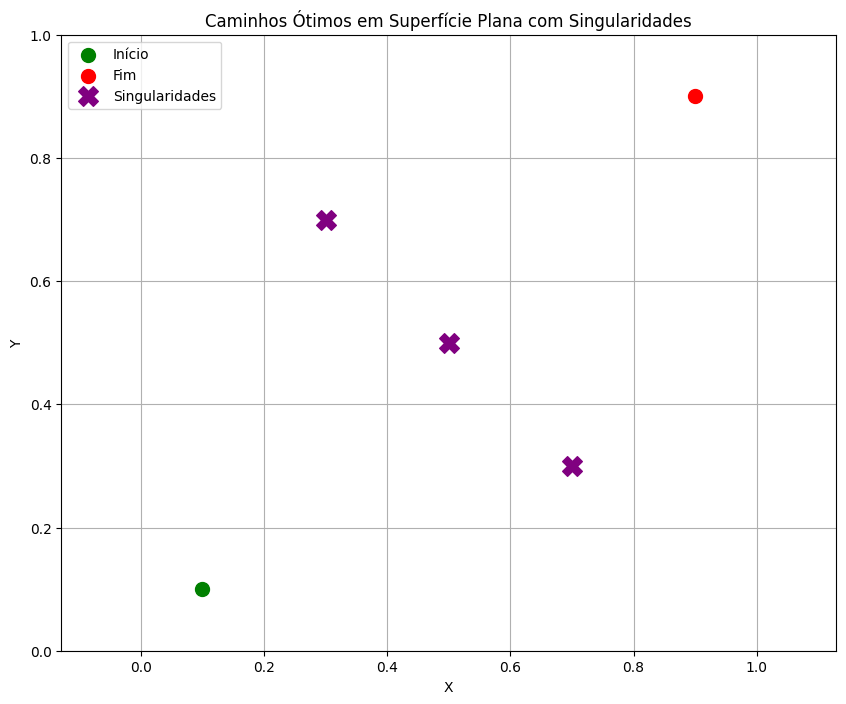

In [5]:
plt.figure(figsize=(10, 8))
plt.scatter(start_point[0], start_point[1], color='green', s=100, zorder=5, label='Início')
plt.scatter(end_point[0], end_point[1], color='red', s=100, zorder=5, label='Fim')
plt.scatter(singularities[:, 0], singularities[:, 1], color='purple', s=200, marker='X', zorder=4, label='Singularidades')

colors = ['blue', 'orange', 'green']
i = 0
for path_name, data in optimal_paths.items():
    plt.plot(data['x'], data['y'], color=colors[i % len(colors)], linestyle='-', linewidth=2, 
             label=f'{path_name} (Custo: {data["cost"]:.2f})')
    i += 1

plt.title('Caminhos Ótimos em Superfície Plana com Singularidades')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.legend()
plt.axis('equal') # Garante que as proporções X e Y são iguais
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

Tentando otimizar para o caminho: straight
   Falha para straight: STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT
   Último custo: 48.0336
Tentando otimizar para o caminho: bend_up
   Falha para bend_up: STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT
   Último custo: 43.2564
Tentando otimizar para o caminho: bend_down


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


   Falha para bend_down: STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT
   Último custo: 9.1032

Nenhum caminho ótimo encontrado.


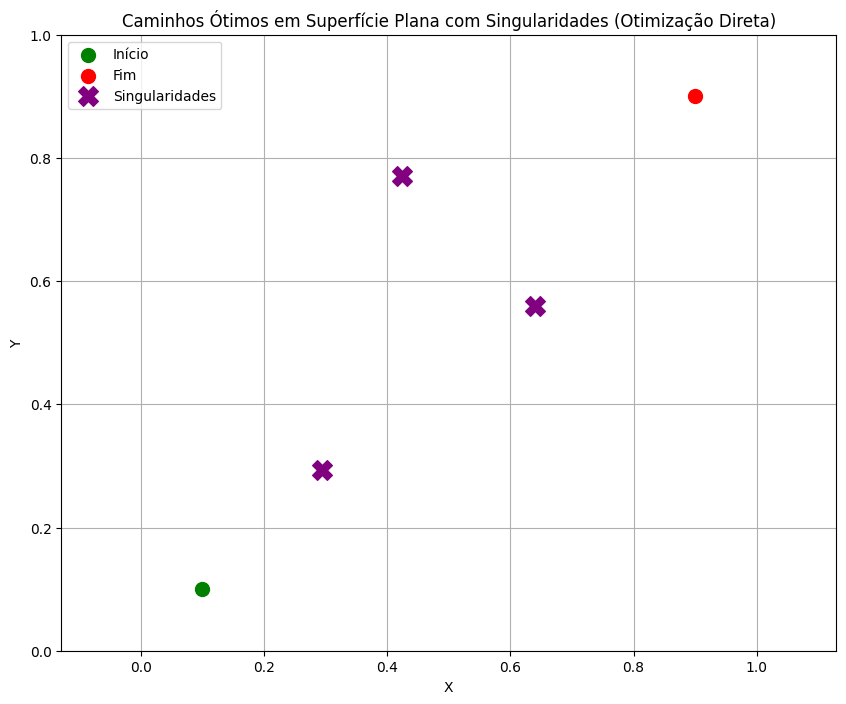

In [6]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# --- 1. Definição da Superfície e Singularidades ---

# Pontos de início e fim
start_point = np.array([0.1, 0.1])
end_point = np.array([0.9, 0.9])

# Geração de singularidades aleatórias
np.random.seed(42) # Para reprodutibilidade
num_singularities = 3
singularities = np.random.rand(num_singularities, 2) * 0.6 + 0.2

# Ajustar uma singularidade para ilustrar a homotopia mais claramente
# Comente ou mude a posição se quiser singularidades puramente aleatórias


# --- 2. Definição do Potencial "Jacobiano" h(x,y) ---

# Pequena constante para evitar divisão por zero e suavizar o potencial
epsilon_h = 1e-6 

def h_potential(x, y, singularities, epsilon):
    """
    Calcula a função h(x,y) que penaliza a proximidade às singularidades.
    h é pequena perto das singularidades e grande longe delas.
    """
    prod_dist_sq = 1.0
    for sx, sy in singularities:
        dist_sq = (x - sx)**2 + (y - sy)**2
        prod_dist_sq *= (dist_sq + epsilon)
    return np.sqrt(prod_dist_sq)

# --- 3. Função Objetivo para Otimização Direta ---

def total_path_cost(path_flat, start_p, end_p, singularities, epsilon_h):
    """
    Calcula o custo total de um caminho.
    path_flat: Array 1D de pontos intermediários [x0,y0, x1,y1, ..., xN-1,yN-1]
               Os pontos de início e fim são fixos e não estão em path_flat.
    """
    
    # Adicionar pontos de início e fim para formar o caminho completo
    num_intermediate_points = len(path_flat) // 2
    path_2d = path_flat.reshape(num_intermediate_points, 2)
    full_path = np.vstack([start_p, path_2d, end_p])

    total_cost = 0.0
    
    for i in range(len(full_path) - 1):
        p1 = full_path[i]
        p2 = full_path[i+1]
        
        segment_length = np.linalg.norm(p2 - p1)
        
        # Ponto médio do segmento para avaliar o potencial
        mid_x = (p1[0] + p2[0]) / 2
        mid_y = (p1[1] + p2[1]) / 2
        
        h_val = h_potential(mid_x, mid_y, singularities, epsilon_h)
        
        # Custo do segmento: comprimento / h_val
        # O custo é alto quando h_val é pequeno (perto de singularidades)
        cost_segment = segment_length / h_val
        total_cost += cost_segment
        
    return total_cost

# --- 4. Geração de Caminhos Iniciais (Homotopia) ---

def generate_initial_guess_direct(num_intermediate_points, start_p, end_p, path_type='straight', offset=0.1):
    """
    Gera diferentes estimativas iniciais (apenas pontos intermediários)
    para explorar classes de homotopia.
    Retorna um array 1D achatado [x0,y0, x1,y1, ...]
    """
    
    t_vals = np.linspace(0, 1, num_intermediate_points + 2) # Inclui start/end para interpolação
    x_total = np.linspace(start_p[0], end_p[0], num_intermediate_points + 2)
    y_total = np.linspace(start_p[1], end_p[1], num_intermediate_points + 2)

    if path_type == 'bend_up':
        y_total += np.sin(np.pi * t_vals) * offset
    elif path_type == 'bend_down':
        y_total -= np.sin(np.pi * t_vals) * offset
    
    # Retornar apenas os pontos intermediários, achatados
    return np.array([x_total[1:-1], y_total[1:-1]]).T.flatten()

# --- 5. Resolução e Comparação dos Caminhos ---

num_intermediate_points = 50 # Número de pontos internos para o caminho

initial_guesses = {
    "straight": generate_initial_guess_direct(num_intermediate_points, start_point, end_point, 'straight'),
    "bend_up": generate_initial_guess_direct(num_intermediate_points, start_point, end_point, 'bend_up', offset=0.2),
    "bend_down": generate_initial_guess_direct(num_intermediate_points, start_point, end_point, 'bend_down', offset=0.2),
}

optimal_paths = {}

for path_name, initial_path_flat in initial_guesses.items():
    print(f"Tentando otimizar para o caminho: {path_name}")
    try:
        # Definir limites para as coordenadas (opcional, mas bom para manter o caminho na região)
        # Por exemplo, limitar x e y entre 0 e 1
        bounds = [(0, 1) for _ in range(len(initial_path_flat))]

        # Usar um otimizador robusto para problemas não-lineares
        # 'L-BFGS-B' é um bom ponto de partida, suporta limites.
        # 'SLSQP' também é uma boa opção e suporta restrições lineares/não-lineares se você precisar depois.
        res = minimize(total_path_cost, initial_path_flat, 
                       args=(start_point, end_point, singularities, epsilon_h), 
                       method='L-BFGS-B', 
                       bounds=bounds,
                       options={'maxiter': 1000, 'disp': False}) # disp=True para ver o progresso

        if res.success:
            print(f"   Sucesso para {path_name}.")
            # Recuperar o caminho otimizado
            optimized_intermediate_points = res.x.reshape(num_intermediate_points, 2)
            full_optimized_path = np.vstack([start_point, optimized_intermediate_points, end_point])
            
            optimal_paths[path_name] = {
                'path': full_optimized_path,
                'cost': res.fun # res.fun é o valor mínimo da função objetivo
            }
            print(f"   Custo total para {path_name}: {res.fun:.4f}")
        else:
            print(f"   Falha para {path_name}: {res.message}")
            print(f"   Último custo: {res.fun:.4f}") # Ainda pode ter um custo, mesmo se não convergir completamente
    except Exception as e:
        print(f"   Erro inesperado para {path_name}: {e}")

# Encontrar o caminho globalmente ótimo
if optimal_paths:
    best_path_name = min(optimal_paths, key=lambda name: optimal_paths[name]['cost'])
    print(f"\nO caminho globalmente ótimo é: {best_path_name} com custo {optimal_paths[best_path_name]['cost']:.4f}")
else:
    print("\nNenhum caminho ótimo encontrado.")

# --- 6. Visualização ---

plt.figure(figsize=(10, 8))
plt.scatter(start_point[0], start_point[1], color='green', s=100, zorder=5, label='Início')
plt.scatter(end_point[0], end_point[1], color='red', s=100, zorder=5, label='Fim')
plt.scatter(singularities[:, 0], singularities[:, 1], color='purple', s=200, marker='X', zorder=4, label='Singularidades')

colors = ['blue', 'orange', 'green']
i = 0
for path_name, data in optimal_paths.items():
    path_coords = data['path']
    plt.plot(path_coords[:, 0], path_coords[:, 1], color=colors[i % len(colors)], linestyle='-', linewidth=2, 
             label=f'{path_name} (Custo: {data["cost"]:.2f})')
    i += 1

plt.title('Caminhos Ótimos em Superfície Plana com Singularidades (Otimização Direta)')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.legend()
plt.axis('equal') # Garante que as proporções X e Y são iguais
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Buscando caminho de (10, 10) para (90, 90) na grade 100x100...
Caminho encontrado com sucesso! Custo total: 11.8701


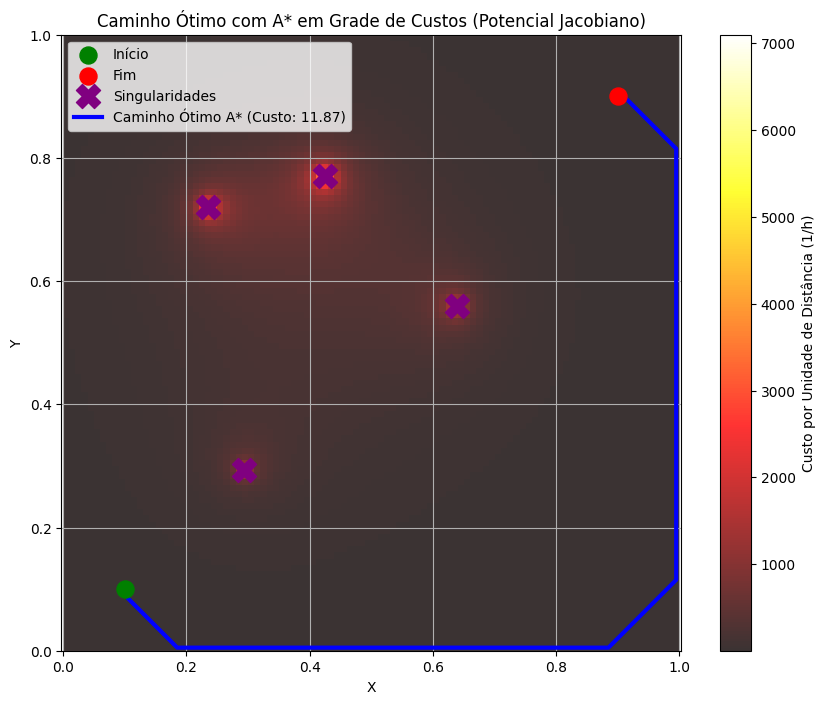

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from heapq import heappop, heappush # Para a fila de prioridade do A*

# --- 1. Definição da Superfície e Singularidades ---

# Pontos de início e fim no espaço (0 a 1)
start_point_real = np.array([0.1, 0.1])
end_point_real = np.array([0.9, 0.9])

# Geração de singularidades aleatórias
np.random.seed(42) # Para reprodutibilidade
num_singularities = 4
singularities_real = np.random.rand(num_singularities, 2) * 0.6 + 0.2



# --- 2. Definição do Potencial "Jacobiano" h(x,y) ---

epsilon_h = 1e-6 # Pequena constante para evitar divisão por zero e suavizar o potencial

def h_potential(x, y, singularities, epsilon):
    """
    Calcula a função h(x,y) que penaliza a proximidade às singularidades.
    h é pequena perto das singularidades e grande longe delas.
    """
    prod_dist_sq = 1.0
    for sx, sy in singularities:
        dist_sq = (x - sx)**2 + (y - sy)**2
        prod_dist_sq *= (dist_sq + epsilon)
    return np.sqrt(prod_dist_sq)

# --- 3. Configuração da Grade e Mapeamento ---

grid_size = 100 # Número de células por dimensão (e.g., 100x100 grid)
grid_resolution = 1.0 / grid_size # Tamanho de cada célula (se o domínio é de 0 a 1)

def real_to_grid(p_real):
    """Converte coordenadas reais para índices de grade."""
    return (int(p_real[0] * grid_size), int(p_real[1] * grid_size))

def grid_to_real(r, c):
    """Converte índices de grade para coordenadas reais do centro da célula."""
    return (r + 0.5) * grid_resolution, (c + 0.5) * grid_resolution

# Mapear pontos de início/fim para a grade
start_node = real_to_grid(start_point_real)
end_node = real_to_grid(end_point_real)

# Criar o mapa de custos para a grade
cost_map = np.zeros((grid_size, grid_size))
for r in range(grid_size):
    for c in range(grid_size):
        x_real, y_real = grid_to_real(r, c)
        # O custo por unidade de distância é 1 / h(x,y)
        cost_map[r, c] = 1.0 / h_potential(x_real, y_real, singularities_real, epsilon_h)

# --- 4. Algoritmo A* ---

# Direções possíveis (8-direções: horizontal, vertical, diagonal)
# (dr, dc) = (delta_row, delta_col)
directions = [
    (0, 1), (0, -1), (1, 0), (-1, 0), # H/V
    (1, 1), (1, -1), (-1, 1), (-1, -1) # Diagonal
]
# Custos associados (distância euclidiana para cada direção)
direction_costs = [
    grid_resolution, grid_resolution, grid_resolution, grid_resolution, # H/V = 1 * resolution
    np.sqrt(2) * grid_resolution, np.sqrt(2) * grid_resolution, 
    np.sqrt(2) * grid_resolution, np.sqrt(2) * grid_resolution # Diagonal = sqrt(2) * resolution
]

def heuristic(node_a, node_b):
    """Heurística: Distância Euclidiana em células."""
    return np.sqrt((node_a[0] - node_b[0])**2 + (node_a[1] - node_b[1])**2) * grid_resolution

def a_star_search(start_node, end_node, cost_map, directions, direction_costs):
    rows, cols = cost_map.shape
    
    # Fila de prioridade: (f_score, g_score, node, path)
    # f_score = g_score + h_score
    open_set = [(0, 0, start_node, [start_node])] # (f_score, g_score, node, path)
    
    # Mapa para armazenar o menor g_score encontrado para cada nó
    g_score = {start_node: 0}
    
    # Mapa para reconstruir o caminho (não necessário se o path é armazenado na fila)
    # came_from = {} 

    while open_set:
        current_f, current_g, current_node, current_path = heappop(open_set)

        if current_node == end_node:
            return current_path, current_g # Path encontrado e seu custo total

        # Explorar vizinhos
        for i, (dr, dc) in enumerate(directions):
            neighbor_r, neighbor_c = current_node[0] + dr, current_node[1] + dc

            # Verificar limites da grade
            if not (0 <= neighbor_r < rows and 0 <= neighbor_c < cols):
                continue
            
            # Custo de mover para o vizinho:
            # Distância euclidiana * custo da célula vizinha (1/h)
            # Ou uma média do custo da célula atual e vizinha para suavizar
            cost_to_neighbor = direction_costs[i] * cost_map[neighbor_r, neighbor_c]
            
            tentative_g_score = current_g + cost_to_neighbor

            if neighbor_r < 0 or neighbor_r >= rows or neighbor_c < 0 or neighbor_c >= cols:
                continue # Fora da grade

            if tentative_g_score < g_score.get((neighbor_r, neighbor_c), float('inf')):
                g_score[(neighbor_r, neighbor_c)] = tentative_g_score
                h_score = heuristic((neighbor_r, neighbor_c), end_node)
                f_score = tentative_g_score + h_score
                
                # Adicionar o nó vizinho à fila de prioridade
                heappush(open_set, (f_score, tentative_g_score, (neighbor_r, neighbor_c), current_path + [(neighbor_r, neighbor_c)]))

    return None, float('inf') # Nenhum caminho encontrado

# --- 5. Execução do A* para encontrar o caminho ---

print(f"Buscando caminho de {start_node} para {end_node} na grade {grid_size}x{grid_size}...")
optimal_grid_path, total_cost_astar = a_star_search(start_node, end_node, cost_map, directions, direction_costs)

if optimal_grid_path:
    print(f"Caminho encontrado com sucesso! Custo total: {total_cost_astar:.4f}")
    
    # Converter caminho da grade para coordenadas reais para plotagem
    optimal_real_path = np.array([grid_to_real(r, c) for r, c in optimal_grid_path])
else:
    print("Nenhum caminho encontrado. Verifique a resolução da grade ou se os obstáculos bloqueiam totalmente o caminho.")


# --- 6. Visualização ---

plt.figure(figsize=(10, 8))

# Plotar o mapa de custos como imagem de fundo (valores de 1/h(x,y))
plt.imshow(cost_map.T, cmap='hot', origin='lower', extent=[0, 1, 0, 1], alpha=0.8) # Transposto e 'lower' para corresponder a (x,y)
plt.colorbar(label='Custo por Unidade de Distância (1/h)')

plt.scatter(start_point_real[0], start_point_real[1], color='green', s=150, zorder=5, label='Início', marker='o')
plt.scatter(end_point_real[0], end_point_real[1], color='red', s=150, zorder=5, label='Fim', marker='o')
plt.scatter(singularities_real[:, 0], singularities_real[:, 1], color='purple', s=300, marker='X', zorder=4, label='Singularidades')

if optimal_grid_path:
    plt.plot(optimal_real_path[:, 0], optimal_real_path[:, 1], color='blue', linestyle='-', linewidth=3, 
             label=f'Caminho Ótimo A* (Custo: {total_cost_astar:.2f})', zorder=3)

plt.title('Caminho Ótimo com A* em Grade de Custos (Potencial Jacobiano)')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

--- Etapa 1: Busca Global com A* ---
A* encontrou um caminho na grade com custo: 11.2546

--- Etapa 2: Suavização do Caminho com Otimização Contínua ---


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Otimização contínua falhou: STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT
Usando o caminho mais próximo encontrado. Custo: 11.0675


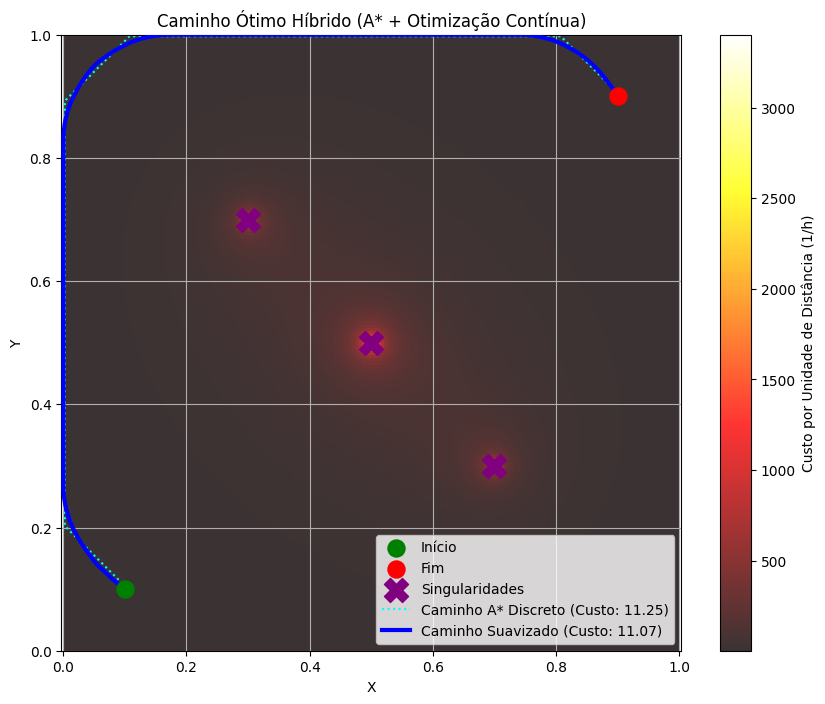

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from heapq import heappop, heappush # Para a fila de prioridade do A*
from scipy.optimize import minimize # Para a etapa de suavização

# --- 1. Definição da Superfície e Singularidades ---

# Pontos de início e fim no espaço (0 a 1)
start_point_real = np.array([0.1, 0.1])
end_point_real = np.array([0.9, 0.9])

# Geração de singularidades (as mesmas do exemplo anterior)
num_singularities = 3
singularities_real = np.array([
    [0.5, 0.5],  # Uma singularidade central
    [0.3, 0.7],  # Outra singularidade
    [0.7, 0.3]   # Mais uma
])

# --- 2. Definição do Potencial "Jacobiano" h(x,y) ---

epsilon_h = 1e-6 # Pequena constante para evitar divisão por zero e suavizar o potencial

def h_potential(x, y, singularities, epsilon):
    """
    Calcula a função h(x,y) que penaliza a proximidade às singularidades.
    h é pequena perto das singularidades e grande longe delas.
    """
    # Evitar log de zero, ou apenas usar o produto
    prod_dist_sq = 1.0
    for sx, sy in singularities:
        dist_sq = (x - sx)**2 + (y - sy)**2
        prod_dist_sq *= (dist_sq + epsilon)
    return np.sqrt(prod_dist_sq)

# --- 3. Configuração da Grade e Mapeamento (para A*) ---

grid_size = 200 # Aumentei a resolução para um A* inicial melhor
grid_resolution = 1.0 / grid_size # Tamanho de cada célula (se o domínio é de 0 a 1)

def real_to_grid(p_real):
    """Converte coordenadas reais para índices de grade, garantindo que estejam dentro dos limites."""
    r = int(np.clip(p_real[0] * grid_size, 0, grid_size - 1))
    c = int(np.clip(p_real[1] * grid_size, 0, grid_size - 1))
    return (r, c)

def grid_to_real(r, c):
    """Converte índices de grade para coordenadas reais do centro da célula."""
    return (r + 0.5) * grid_resolution, (c + 0.5) * grid_resolution

# Mapear pontos de início/fim para a grade
start_node = real_to_grid(start_point_real)
end_node = real_to_grid(end_point_real)

# Criar o mapa de custos para a grade
cost_map = np.zeros((grid_size, grid_size))
for r in range(grid_size):
    for c in range(grid_size):
        x_real, y_real = grid_to_real(r, c)
        cost_map[r, c] = 1.0 / h_potential(x_real, y_real, singularities_real, epsilon_h)

# --- 4. Algoritmo A* (mesmo do exemplo anterior) ---

directions = [
    (0, 1), (0, -1), (1, 0), (-1, 0), # H/V
    (1, 1), (1, -1), (-1, 1), (-1, -1) # Diagonal
]
direction_costs = [
    grid_resolution, grid_resolution, grid_resolution, grid_resolution, # H/V = 1 * resolution
    np.sqrt(2) * grid_resolution, np.sqrt(2) * grid_resolution, 
    np.sqrt(2) * grid_resolution, np.sqrt(2) * grid_resolution # Diagonal = sqrt(2) * resolution
]

def heuristic(node_a, node_b):
    """Heurística: Distância Euclidiana em células."""
    return np.sqrt((node_a[0] - node_b[0])**2 + (node_a[1] - node_b[1])**2) * grid_resolution

def a_star_search(start_node, end_node, cost_map, directions, direction_costs):
    rows, cols = cost_map.shape
    open_set = [(0, 0, start_node, [start_node])] 
    g_score = {start_node: 0}
    
    while open_set:
        current_f, current_g, current_node, current_path = heappop(open_set)

        if current_node == end_node:
            return current_path, current_g 

        for i, (dr, dc) in enumerate(directions):
            neighbor_r, neighbor_c = current_node[0] + dr, current_node[1] + dc

            if not (0 <= neighbor_r < rows and 0 <= neighbor_c < cols):
                continue
            
            # Custo de mover para o vizinho: Distância euclidiana * custo médio da célula
            # Usando o custo da célula vizinha para simplicidade e A* padrão
            cost_to_neighbor = direction_costs[i] * cost_map[neighbor_r, neighbor_c]
            
            tentative_g_score = current_g + cost_to_neighbor

            if tentative_g_score < g_score.get((neighbor_r, neighbor_c), float('inf')):
                g_score[(neighbor_r, neighbor_c)] = tentative_g_score
                h_score = heuristic((neighbor_r, neighbor_c), end_node)
                f_score = tentative_g_score + h_score
                heappush(open_set, (f_score, tentative_g_score, (neighbor_r, neighbor_c), current_path + [(neighbor_r, neighbor_c)]))

    return None, float('inf')

# --- 5. Otimização Contínua (Suavização) ---

def total_path_cost_continuous(path_flat, start_p, end_p, singularities, epsilon_h):
    """
    Calcula o custo total de um caminho contínuo (para o otimizador).
    path_flat: Array 1D de pontos intermediários [x0,y0, x1,y1, ..., xN-1,yN-1]
    """
    num_intermediate_points = len(path_flat) // 2
    path_2d = path_flat.reshape(num_intermediate_points, 2)
    full_path = np.vstack([start_p, path_2d, end_p])

    total_cost = 0.0
    for i in range(len(full_path) - 1):
        p1 = full_path[i]
        p2 = full_path[i+1]
        
        segment_length = np.linalg.norm(p2 - p1)
        
        # Ponto médio do segmento para avaliar o potencial
        mid_x = (p1[0] + p2[0]) / 2
        mid_y = (p1[1] + p2[1]) / 2
        
        h_val = h_potential(mid_x, mid_y, singularities, epsilon_h)
        
        cost_segment = segment_length / h_val
        total_cost += cost_segment
        
    return total_cost

# --- Execução Principal ---

print("--- Etapa 1: Busca Global com A* ---")
optimal_grid_path_nodes, total_cost_astar_grid = a_star_search(start_node, end_node, cost_map, directions, direction_costs)

if not optimal_grid_path_nodes:
    print("Erro: A* não encontrou um caminho na grade. O caminho pode estar completamente bloqueado ou a grade é muito grossa.")
    exit()

print(f"A* encontrou um caminho na grade com custo: {total_cost_astar_grid:.4f}")

# Converter o caminho da grade para coordenadas reais
optimal_grid_path_real = np.array([grid_to_real(r, c) for r, c in optimal_grid_path_nodes])

print("\n--- Etapa 2: Suavização do Caminho com Otimização Contínua ---")

# Usar o caminho A* como chute inicial para o otimizador contínuo
# Extrair apenas os pontos intermediários, pois start_point e end_point são fixos
initial_guess_for_smooth = optimal_grid_path_real[1:-1].flatten()

# Definir limites para as coordenadas (opcional, mas bom para manter o caminho na região)
bounds = [(0, 1) for _ in range(len(initial_guess_for_smooth))]

try:
    res = minimize(total_path_cost_continuous, initial_guess_for_smooth, 
                   args=(start_point_real, end_point_real, singularities_real, epsilon_h), 
                   method='L-BFGS-B', # Bom para problemas de média escala com limites
                   bounds=bounds,
                   options={'maxiter': 5000, 'disp': True, 'ftol': 1e-7}) # disp=True para ver o progresso

    if res.success:
        print(f"Otimização contínua bem-sucedida! Custo final: {res.fun:.4f}")
        optimized_intermediate_points = res.x.reshape(-1, 2)
        final_smooth_path = np.vstack([start_point_real, optimized_intermediate_points, end_point_real])
        final_cost = res.fun
    else:
        print(f"Otimização contínua falhou: {res.message}")
        print(f"Usando o caminho mais próximo encontrado. Custo: {res.fun:.4f}")
        optimized_intermediate_points = res.x.reshape(-1, 2)
        final_smooth_path = np.vstack([start_point_real, optimized_intermediate_points, end_point_real])
        final_cost = res.fun

except Exception as e:
    print(f"Erro inesperado durante a otimização contínua: {e}")
    print("Usando o caminho A* como o caminho final (sem suavização).")
    final_smooth_path = optimal_grid_path_real
    final_cost = total_cost_astar_grid

# --- Visualização ---

plt.figure(figsize=(10, 8))

# Plotar o mapa de custos como imagem de fundo
plt.imshow(cost_map.T, cmap='hot', origin='lower', extent=[0, 1, 0, 1], alpha=0.8)
plt.colorbar(label='Custo por Unidade de Distância (1/h)')

plt.scatter(start_point_real[0], start_point_real[1], color='green', s=150, zorder=5, label='Início', marker='o')
plt.scatter(end_point_real[0], end_point_real[1], color='red', s=150, zorder=5, label='Fim', marker='o')
plt.scatter(singularities_real[:, 0], singularities_real[:, 1], color='purple', s=300, marker='X', zorder=4, label='Singularidades')

# Plotar o caminho A* original (para comparação)
plt.plot(optimal_grid_path_real[:, 0], optimal_grid_path_real[:, 1], color='cyan', linestyle=':', linewidth=1.5, 
         label=f'Caminho A* Discreto (Custo: {total_cost_astar_grid:.2f})', zorder=2)

# Plotar o caminho suavizado
plt.plot(final_smooth_path[:, 0], final_smooth_path[:, 1], color='blue', linestyle='-', linewidth=3, 
         label=f'Caminho Suavizado (Custo: {final_cost:.2f})', zorder=3)

plt.title('Caminho Ótimo Híbrido (A* + Otimização Contínua)')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

--- Etapa 1: Busca Global com A* ---
A* encontrou um caminho na grade com custo: 28913.3471

--- Etapa 2: Suavização do Caminho com Otimização Contínua ---


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Otimização contínua falhou: STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT
Usando o caminho mais próximo encontrado. Custo: 28463.3453


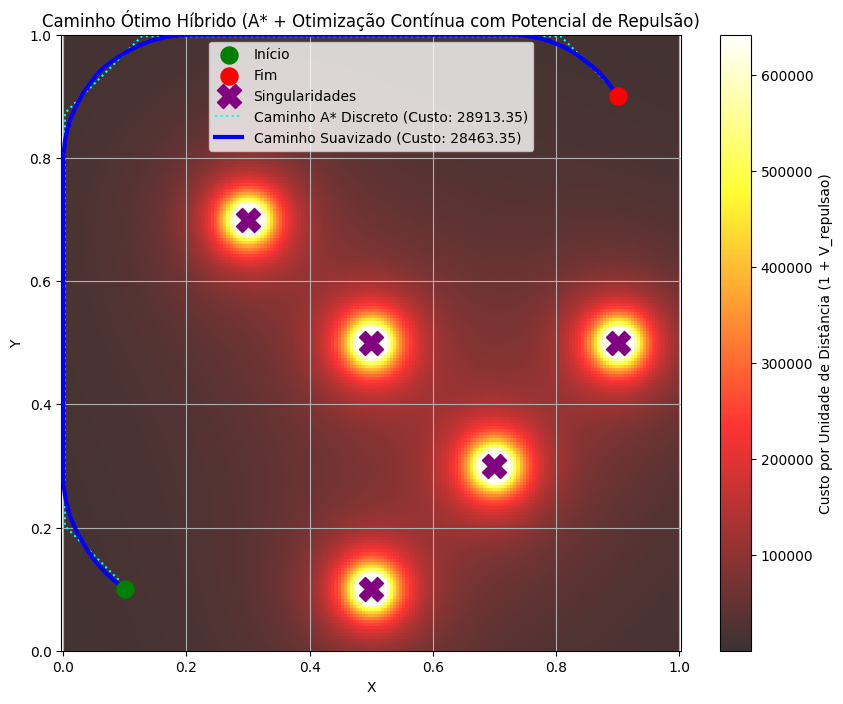

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from heapq import heappop, heappush # Para a fila de prioridade do A*
from scipy.optimize import minimize # Para a etapa de suavização

# --- 1. Definição da Superfície e Singularidades ---

# Pontos de início e fim no espaço (0 a 1)
start_point_real = np.array([0.1, 0.1])
end_point_real = np.array([0.9, 0.9])

# Geração de singularidades (as mesmas do exemplo anterior)
num_singularities = 3
singularities_real = np.array([
    [0.5, 0.5],  # Uma singularidade central
    [0.3, 0.7],  # Outra singularidade
    [0.7, 0.3],  # Mais uma
    [0.5, 0.1],  # Adicionando uma singularidade para forçar mais desvio
    [0.9, 0.5]
])

# --- 2. Definição do Potencial de Repulsão ---

epsilon_repulsion = 1e-3 # Aumentei epsilon para suavizar um pouco mais o gradiente
K_repulsion = 1000.0    # Constante de escala para a força da repulsão. Ajuste conforme necessário.

def repulsion_potential(x, y, singularities, epsilon, K):
    """
    Calcula o potencial de repulsão.
    Soma de inversos do quadrado da distância + epsilon.
    """
    total_repulsion = 0.0
    for sx, sy in singularities:
        dist_sq = (x - sx)**2 + (y - sy)**2
        total_repulsion += K / (dist_sq + epsilon)
    return total_repulsion

# --- 3. Configuração da Grade e Mapeamento (para A*) ---

grid_size = 200 # Resolução da grade
grid_resolution = 1.0 / grid_size 

def real_to_grid(p_real):
    r = int(np.clip(p_real[0] * grid_size, 0, grid_size - 1))
    c = int(np.clip(p_real[1] * grid_size, 0, grid_size - 1))
    return (r, c)

def grid_to_real(r, c):
    return (r + 0.5) * grid_resolution, (c + 0.5) * grid_resolution

# Mapear pontos de início/fim para a grade
start_node = real_to_grid(start_point_real)
end_node = real_to_grid(end_point_real)

# Criar o mapa de custos para a grade
cost_map_grid = np.zeros((grid_size, grid_size))
for r in range(grid_size):
    for c in range(grid_size):
        x_real, y_real = grid_to_real(r, c)
        # Custo da célula: 1 (custo base de comprimento) + potencial de repulsão
        # O custo por unidade de distância é (1 + V_repulsao)
        cost_map_grid[r, c] = 1.0 + repulsion_potential(x_real, y_real, singularities_real, epsilon_repulsion, K_repulsion)

# --- 4. Algoritmo A* (mesmo do exemplo anterior, usando o novo cost_map_grid) ---

directions = [
    (0, 1), (0, -1), (1, 0), (-1, 0), # H/V
    (1, 1), (1, -1), (-1, 1), (-1, -1) # Diagonal
]
direction_costs = [
    grid_resolution, grid_resolution, grid_resolution, grid_resolution, # H/V = 1 * resolution
    np.sqrt(2) * grid_resolution, np.sqrt(2) * grid_resolution, 
    np.sqrt(2) * grid_resolution, np.sqrt(2) * grid_resolution # Diagonal = sqrt(2) * resolution
]

def heuristic(node_a, node_b):
    return np.sqrt((node_a[0] - node_b[0])**2 + (node_a[1] - node_b[1])**2) * grid_resolution

def a_star_search(start_node, end_node, cost_map, directions, direction_costs):
    rows, cols = cost_map.shape
    open_set = [(0, 0, start_node, [start_node])] 
    g_score = {start_node: 0}
    
    while open_set:
        current_f, current_g, current_node, current_path = heappop(open_set)

        if current_node == end_node:
            return current_path, current_g 

        for i, (dr, dc) in enumerate(directions):
            neighbor_r, neighbor_c = current_node[0] + dr, current_node[1] + dc

            if not (0 <= neighbor_r < rows and 0 <= neighbor_c < cols):
                continue
            
            # Custo de mover para o vizinho: Distância euclidiana * custo da célula vizinha
            # O custo_map_grid já contém (1 + V_repulsao)
            cost_to_neighbor = direction_costs[i] * cost_map[neighbor_r, neighbor_c] 
            
            tentative_g_score = current_g + cost_to_neighbor

            if tentative_g_score < g_score.get((neighbor_r, neighbor_c), float('inf')):
                g_score[(neighbor_r, neighbor_c)] = tentative_g_score
                h_score = heuristic((neighbor_r, neighbor_c), end_node)
                f_score = tentative_g_score + h_score
                heappush(open_set, (f_score, tentative_g_score, (neighbor_r, neighbor_c), current_path + [(neighbor_r, neighbor_c)]))

    return None, float('inf')

# --- 5. Otimização Contínua (Suavização) ---

def total_path_cost_continuous(path_flat, start_p, end_p, singularities, epsilon_repulsion, K_repulsion):
    """
    Calcula o custo total de um caminho contínuo (para o otimizador),
    usando o novo potencial de repulsão.
    """
    num_intermediate_points = len(path_flat) // 2
    path_2d = path_flat.reshape(num_intermediate_points, 2)
    full_path = np.vstack([start_p, path_2d, end_p])

    total_cost = 0.0
    for i in range(len(full_path) - 1):
        p1 = full_path[i]
        p2 = full_path[i+1]
        
        segment_length = np.linalg.norm(p2 - p1)
        
        # Ponto médio do segmento para avaliar o potencial
        mid_x = (p1[0] + p2[0]) / 2
        mid_y = (p1[1] + p2[1]) / 2
        
        # O custo é length * (1 + repulsion_potential)
        repulsion_val = repulsion_potential(mid_x, mid_y, singularities, epsilon_repulsion, K_repulsion)
        cost_segment = segment_length * (1.0 + repulsion_val) # Adiciona custo base de comprimento
        total_cost += cost_segment
        
    return total_cost

# --- Execução Principal ---

print("--- Etapa 1: Busca Global com A* ---")
optimal_grid_path_nodes, total_cost_astar_grid = a_star_search(start_node, end_node, cost_map_grid, directions, direction_costs)

if not optimal_grid_path_nodes:
    print("Erro: A* não encontrou um caminho na grade. O caminho pode estar completamente bloqueado ou a grade é muito grossa.")
    exit()

print(f"A* encontrou um caminho na grade com custo: {total_cost_astar_grid:.4f}")

# Converter o caminho da grade para coordenadas reais
optimal_grid_path_real = np.array([grid_to_real(r, c) for r, c in optimal_grid_path_nodes])

print("\n--- Etapa 2: Suavização do Caminho com Otimização Contínua ---")

# Usar o caminho A* como chute inicial para o otimizador contínuo
# Extrair apenas os pontos intermediários, pois start_point e end_point são fixos
initial_guess_for_smooth = optimal_grid_path_real[1:-1].flatten()

# Definir limites para as coordenadas (opcional, mas bom para manter o caminho na região)
bounds = [(0, 1) for _ in range(len(initial_guess_for_smooth))]

try:
    res = minimize(total_path_cost_continuous, initial_guess_for_smooth, 
                   args=(start_point_real, end_point_real, singularities_real, epsilon_repulsion, K_repulsion), 
                   method='L-BFGS-B', 
                   bounds=bounds,
                   options={'maxiter': 5000, 'disp': True, 'ftol': 1e-7})

    if res.success:
        print(f"Otimização contínua bem-sucedida! Custo final: {res.fun:.4f}")
        optimized_intermediate_points = res.x.reshape(-1, 2)
        final_smooth_path = np.vstack([start_point_real, optimized_intermediate_points, end_point_real])
        final_cost = res.fun
    else:
        print(f"Otimização contínua falhou: {res.message}")
        print(f"Usando o caminho mais próximo encontrado. Custo: {res.fun:.4f}")
        optimized_intermediate_points = res.x.reshape(-1, 2)
        final_smooth_path = np.vstack([start_point_real, optimized_intermediate_points, end_point_real])
        final_cost = res.fun

except Exception as e:
    print(f"Erro inesperado durante a otimização contínua: {e}")
    print("Usando o caminho A* como o caminho final (sem suavização).")
    final_smooth_path = optimal_grid_path_real
    final_cost = total_cost_astar_grid

# --- Visualização ---

plt.figure(figsize=(10, 8))

# Plotar o mapa de custos como imagem de fundo
# Transposto e 'lower' para corresponder a (x,y)
plt.imshow(cost_map_grid.T, cmap='hot', origin='lower', extent=[0, 1, 0, 1], alpha=0.8,
           vmin=1.0, vmax=np.percentile(cost_map_grid, 99)) # Limitar vmax para melhor visualização

plt.colorbar(label='Custo por Unidade de Distância (1 + V_repulsao)')

plt.scatter(start_point_real[0], start_point_real[1], color='green', s=150, zorder=5, label='Início', marker='o')
plt.scatter(end_point_real[0], end_point_real[1], color='red', s=150, zorder=5, label='Fim', marker='o')
plt.scatter(singularities_real[:, 0], singularities_real[:, 1], color='purple', s=300, marker='X', zorder=4, label='Singularidades')

# Plotar o caminho A* original (para comparação)
plt.plot(optimal_grid_path_real[:, 0], optimal_grid_path_real[:, 1], color='cyan', linestyle=':', linewidth=1.5, 
         label=f'Caminho A* Discreto (Custo: {total_cost_astar_grid:.2f})', zorder=2)

# Plotar o caminho suavizado
plt.plot(final_smooth_path[:, 0], final_smooth_path[:, 1], color='blue', linestyle='-', linewidth=3, 
         label=f'Caminho Suavizado (Custo: {final_cost:.2f})', zorder=3)

plt.title('Caminho Ótimo Híbrido (A* + Otimização Contínua com Potencial de Repulsão)')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

--- Etapa 1: Busca Global com A* ---
A* encontrou um caminho na grade com custo: 2.1995

--- Etapa 2: Suavização do Caminho com Otimização Contínua ---


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Otimização contínua bem-sucedida! Custo final: 2.1196


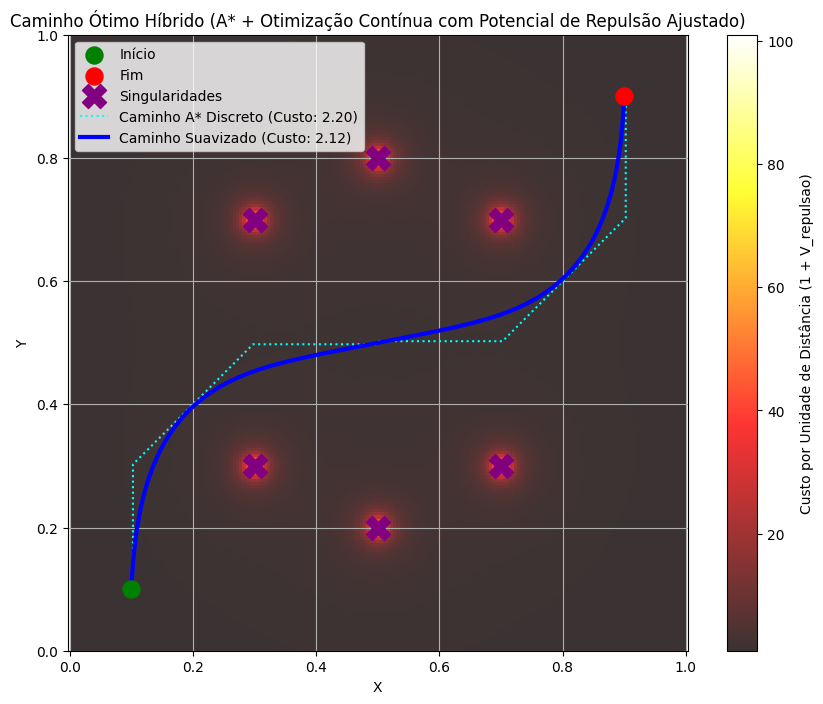

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from heapq import heappop, heappush # Para a fila de prioridade do A*
from scipy.optimize import minimize # Para a etapa de suavização

# --- 1. Definição da Superfície e Singularidades ---

# Pontos de início e fim no espaço (0 a 1)
start_point_real = np.array([0.1, 0.1])
end_point_real = np.array([0.9, 0.9])

# Geração de singularidades - Posicionadas para forçar o tangenciamento
# Vamos criar duas "colunas" de singularidades para o caminho passar no meio
singularities_real = np.array([
    [0.3, 0.3], [0.3, 0.7],  # Coluna esquerda
    [0.7, 0.3], [0.7, 0.7],  # Coluna direita
    # Adicionei mais para ter um "corredor" mais claro
    [0.5, 0.2], [0.5, 0.8]   # Para forçar o caminho a se manter no centro vertical
])


# --- 2. Definição do Potencial de Repulsão ---

epsilon_repulsion = 1e-4 # Ajuste: menor epsilon para um pico mais localizado
K_repulsion = 0.01     # Ajuste: K MUITO menor para que o custo base de 1.0 tenha peso

def repulsion_potential(x, y, singularities, epsilon, K):
    total_repulsion = 0.0
    for sx, sy in singularities:
        dist_sq = (x - sx)**2 + (y - sy)**2
        total_repulsion += K / (dist_sq + epsilon)
    return total_repulsion

# --- 3. Configuração da Grade e Mapeamento (para A*) ---

grid_size = 200 # Resolução da grade
grid_resolution = 1.0 / grid_size 

def real_to_grid(p_real):
    r = int(np.clip(p_real[0] * grid_size, 0, grid_size - 1))
    c = int(np.clip(p_real[1] * grid_size, 0, grid_size - 1))
    return (r, c)

def grid_to_real(r, c):
    return (r + 0.5) * grid_resolution, (c + 0.5) * grid_resolution

start_node = real_to_grid(start_point_real)
end_node = real_to_grid(end_point_real)

cost_map_grid = np.zeros((grid_size, grid_size))
for r in range(grid_size):
    for c in range(grid_size):
        x_real, y_real = grid_to_real(r, c)
        cost_map_grid[r, c] = 1.0 + repulsion_potential(x_real, y_real, singularities_real, epsilon_repulsion, K_repulsion)

# --- 4. Algoritmo A* (mesmo do exemplo anterior) ---

directions = [
    (0, 1), (0, -1), (1, 0), (-1, 0), # H/V
    (1, 1), (1, -1), (-1, 1), (-1, -1) # Diagonal
]
direction_costs = [
    grid_resolution, grid_resolution, grid_resolution, grid_resolution, 
    np.sqrt(2) * grid_resolution, np.sqrt(2) * grid_resolution, 
    np.sqrt(2) * grid_resolution, np.sqrt(2) * grid_resolution 
]

def heuristic(node_a, node_b):
    return np.sqrt((node_a[0] - node_b[0])**2 + (node_a[1] - node_b[1])**2) * grid_resolution

def a_star_search(start_node, end_node, cost_map, directions, direction_costs):
    rows, cols = cost_map.shape
    open_set = [(0, 0, start_node, [start_node])] 
    g_score = {start_node: 0}
    
    while open_set:
        current_f, current_g, current_node, current_path = heappop(open_set)

        if current_node == end_node:
            return current_path, current_g 

        for i, (dr, dc) in enumerate(directions):
            neighbor_r, neighbor_c = current_node[0] + dr, current_node[1] + dc

            if not (0 <= neighbor_r < rows and 0 <= neighbor_c < cols):
                continue
            
            cost_to_neighbor = direction_costs[i] * cost_map[neighbor_r, neighbor_c] 
            
            tentative_g_score = current_g + cost_to_neighbor

            if tentative_g_score < g_score.get((neighbor_r, neighbor_c), float('inf')):
                g_score[(neighbor_r, neighbor_c)] = tentative_g_score
                h_score = heuristic((neighbor_r, neighbor_c), end_node)
                f_score = tentative_g_score + h_score
                heappush(open_set, (f_score, tentative_g_score, (neighbor_r, neighbor_c), current_path + [(neighbor_r, neighbor_c)]))

    return None, float('inf')

# --- 5. Otimização Contínua (Suavização) ---

def total_path_cost_continuous(path_flat, start_p, end_p, singularities, epsilon_repulsion, K_repulsion):
    """
    Calcula o custo total de um caminho contínuo (para o otimizador),
    usando o potencial de repulsão ajustado.
    """
    num_intermediate_points = len(path_flat) // 2
    path_2d = path_flat.reshape(num_intermediate_points, 2)
    full_path = np.vstack([start_p, path_2d, end_p])

    total_cost = 0.0
    for i in range(len(full_path) - 1):
        p1 = full_path[i]
        p2 = full_path[i+1]
        
        segment_length = np.linalg.norm(p2 - p1)
        
        mid_x = (p1[0] + p2[0]) / 2
        mid_y = (p1[1] + p2[1]) / 2
        
        repulsion_val = repulsion_potential(mid_x, mid_y, singularities, epsilon_repulsion, K_repulsion)
        cost_segment = segment_length * (1.0 + repulsion_val) 
        total_cost += cost_segment
        
    return total_cost

# --- Execução Principal ---

print("--- Etapa 1: Busca Global com A* ---")
optimal_grid_path_nodes, total_cost_astar_grid = a_star_search(start_node, end_node, cost_map_grid, directions, direction_costs)

if not optimal_grid_path_nodes:
    print("Erro: A* não encontrou um caminho na grade. O caminho pode estar completamente bloqueado ou a grade é muito grossa.")
    exit()

print(f"A* encontrou um caminho na grade com custo: {total_cost_astar_grid:.4f}")

optimal_grid_path_real = np.array([grid_to_real(r, c) for r, c in optimal_grid_path_nodes])

print("\n--- Etapa 2: Suavização do Caminho com Otimização Contínua ---")

# Reduzir o número de pontos para a suavização se o caminho A* for muito longo,
# ou manter um número fixo para otimização mais estável.
# Vou usar um número fixo e interpolar o caminho A* se necessário.
target_smooth_points = 100
if len(optimal_grid_path_real) > target_smooth_points:
    # Subamostrar ou interpolar o caminho A* para ter menos pontos
    indices = np.linspace(0, len(optimal_grid_path_real) - 1, target_smooth_points).astype(int)
    resampled_path = optimal_grid_path_real[indices]
else:
    resampled_path = optimal_grid_path_real

initial_guess_for_smooth = resampled_path[1:-1].flatten()

bounds = [(0, 1) for _ in range(len(initial_guess_for_smooth))]

try:
    res = minimize(total_path_cost_continuous, initial_guess_for_smooth, 
                   args=(start_point_real, end_point_real, singularities_real, epsilon_repulsion, K_repulsion), 
                   method='L-BFGS-B', 
                   bounds=bounds,
                   options={'maxiter': 5000, 'disp': True, 'ftol': 1e-7})

    if res.success:
        print(f"Otimização contínua bem-sucedida! Custo final: {res.fun:.4f}")
        optimized_intermediate_points = res.x.reshape(-1, 2)
        final_smooth_path = np.vstack([start_point_real, optimized_intermediate_points, end_point_real])
        final_cost = res.fun
    else:
        print(f"Otimização contínua falhou: {res.message}")
        print(f"Usando o caminho mais próximo encontrado. Custo: {res.fun:.4f}")
        optimized_intermediate_points = res.x.reshape(-1, 2)
        final_smooth_path = np.vstack([start_point_real, optimized_intermediate_points, end_point_real])
        final_cost = res.fun

except Exception as e:
    print(f"Erro inesperado durante a otimização contínua: {e}")
    print("Usando o caminho A* como o caminho final (sem suavização).")
    final_smooth_path = optimal_grid_path_real
    final_cost = total_cost_astar_grid

# --- Visualização ---

plt.figure(figsize=(10, 8))

# Plotar o mapa de custos como imagem de fundo
plt.imshow(cost_map_grid.T, cmap='hot', origin='lower', extent=[0, 1, 0, 1], alpha=0.8,
           vmin=1.0, vmax=1.0 + K_repulsion / epsilon_repulsion) # Ajustar vmax para mostrar o pico de forma mais razoável

plt.colorbar(label='Custo por Unidade de Distância (1 + V_repulsao)')

plt.scatter(start_point_real[0], start_point_real[1], color='green', s=150, zorder=5, label='Início', marker='o')
plt.scatter(end_point_real[0], end_point_real[1], color='red', s=150, zorder=5, label='Fim', marker='o')
plt.scatter(singularities_real[:, 0], singularities_real[:, 1], color='purple', s=300, marker='X', zorder=4, label='Singularidades')

plt.plot(optimal_grid_path_real[:, 0], optimal_grid_path_real[:, 1], color='cyan', linestyle=':', linewidth=1.5, 
         label=f'Caminho A* Discreto (Custo: {total_cost_astar_grid:.2f})', zorder=2)

plt.plot(final_smooth_path[:, 0], final_smooth_path[:, 1], color='blue', linestyle='-', linewidth=3, 
         label=f'Caminho Suavizado (Custo: {final_cost:.2f})', zorder=3)

plt.title('Caminho Ótimo Híbrido (A* + Otimização Contínua com Potencial de Repulsão Ajustado)')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

Custo inicial: 1.9144
Iteração 1000, Melhor Custo: 1.9144
Iteração 2000, Melhor Custo: 1.9143
Iteração 3000, Melhor Custo: 1.9143
Iteração 4000, Melhor Custo: 1.9143
Iteração 5000, Melhor Custo: 1.9143
Iteração 6000, Melhor Custo: 1.9143
Iteração 7000, Melhor Custo: 1.9143
Iteração 8000, Melhor Custo: 1.9143
Iteração 9000, Melhor Custo: 1.9143
Iteração 10000, Melhor Custo: 1.9143
Iteração 11000, Melhor Custo: 1.9142
Iteração 12000, Melhor Custo: 1.9142
Iteração 13000, Melhor Custo: 1.9142
Iteração 14000, Melhor Custo: 1.9141
Iteração 15000, Melhor Custo: 1.9141
Iteração 16000, Melhor Custo: 1.9141
Iteração 17000, Melhor Custo: 1.9141
Iteração 18000, Melhor Custo: 1.9141
Iteração 19000, Melhor Custo: 1.9140
Iteração 20000, Melhor Custo: 1.9140
Iteração 21000, Melhor Custo: 1.9140
Iteração 22000, Melhor Custo: 1.9140
Iteração 23000, Melhor Custo: 1.9140
Iteração 24000, Melhor Custo: 1.9140
Iteração 25000, Melhor Custo: 1.9139
Iteração 26000, Melhor Custo: 1.9139
Iteração 27000, Melhor Cu

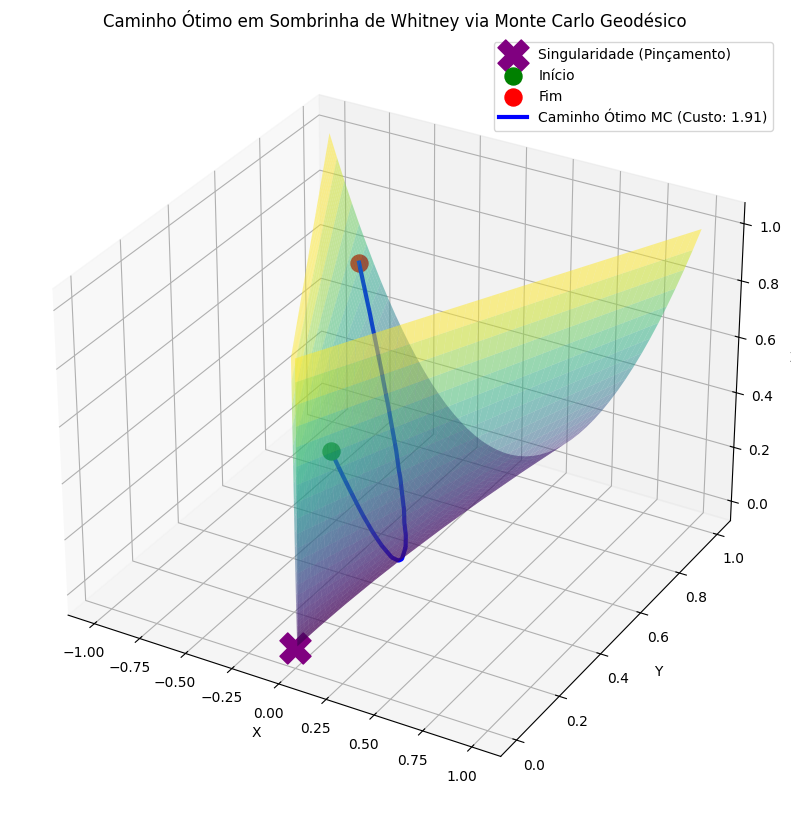

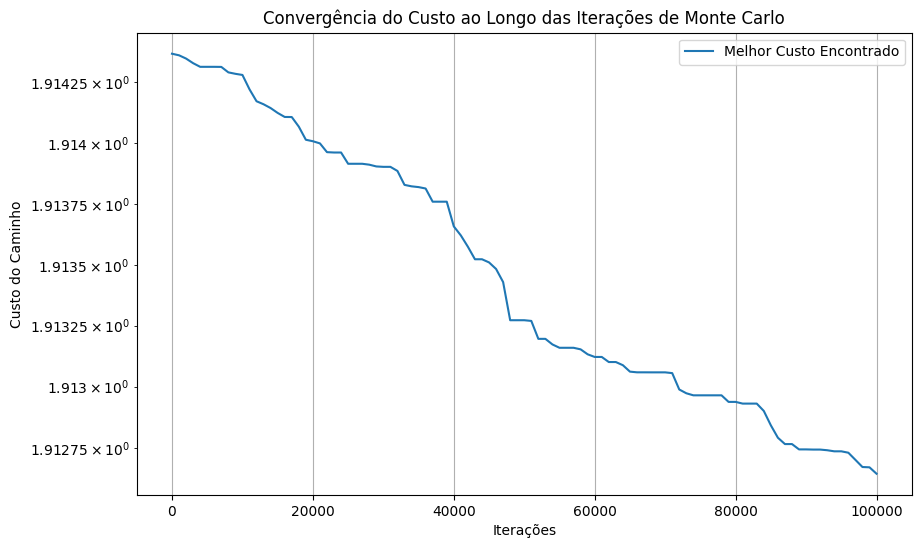

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random # Para a geração de números aleatórios

# --- 1. Definição da Superfície: Sombrinha de Whitney ---

def whitney_umbrella_param(u, v):
    """Parametrização da Sombrinha de Whitney."""
    x = u * v
    y = u
    z = v**2
    return np.array([x, y, z])

def whitney_metric_components(u, v):
    """Calcula os componentes do tensor métrico induzido (E, F, G)."""
    # r_u = (v, 1, 0)
    # r_v = (u, 0, 2v)
    
    E = v**2 + 1
    F = u * v
    G = u**2 + 4 * v**2
    return E, F, G

# --- 2. Definição do Potencial de Repulsão ---

epsilon_repulsion = 1e-4  # Ajuste para suavizar o pico e controlar a "largura"
K_repulsion = 0.005       # Ajuste para a força da repulsão (bem pequena aqui)
                           # Ajuste-a para cima se o caminho cruzar a singularidade.

# Singularidade a evitar no espaço de parâmetros (o ponto de pinçamento)
singularities_param = np.array([[0.0, 0.0]]) 

def repulsion_potential(u, v, singularities, epsilon, K):
    total_repulsion = 0.0
    for su, sv in singularities:
        dist_sq = (u - su)**2 + (v - sv)**2
        total_repulsion += K / (dist_sq + epsilon)
    return total_repulsion

# --- 3. Função de Custo para um Caminho ---

def calculate_path_cost(path_uv, start_uv, end_uv, singularities, epsilon_repulsion, K_repulsion):
    """
    Calcula o custo total de um caminho no espaço de parâmetros (u,v).
    Custo = soma(comprimento_segmento * (1 + V_repulsao_no_meio_do_segmento))
    """
    num_intermediate_points = len(path_uv) // 2
    path_2d_uv = path_uv.reshape(num_intermediate_points, 2)
    full_path_uv = np.vstack([start_uv, path_2d_uv, end_uv])

    total_cost = 0.0
    for i in range(len(full_path_uv) - 1):
        p1_uv = full_path_uv[i]
        p2_uv = full_path_uv[i+1]
        
        du = p2_uv[0] - p1_uv[0]
        dv = p2_uv[1] - p1_uv[1]
        
        # Ponto médio do segmento no espaço (u,v) para avaliar a métrica e o potencial
        mid_u = (p1_uv[0] + p2_uv[0]) / 2
        mid_v = (p1_uv[1] + p2_uv[1]) / 2

        # Calcular componentes da métrica no ponto médio
        E, F, G = whitney_metric_components(mid_u, mid_v)
        
        # Cuidado com E, F, G se u ou v for muito perto de 0 na singularidade (0,0).
        # Se a métrica degenerar (E*G - F*F = 0), a distância seria 0, mas o custo infinito.
        # Nosso potencial de repulsão já trata isso.
        
        # Comprimento do segmento usando a métrica induzida
        segment_length_uv = np.sqrt(E * du**2 + 2 * F * du * dv + G * dv**2)
        
        # Potencial de repulsão no ponto médio
        repulsion_val = repulsion_potential(mid_u, mid_v, singularities, epsilon_repulsion, K_repulsion)
        
        # Custo do segmento: comprimento * (1 + V_repulsao)
        cost_segment = segment_length_uv * (1.0 + repulsion_val) 
        total_cost += cost_segment
        
    return total_cost

# --- 4. Configuração do Monte Carlo Geodésico ---

# Pontos de início e fim no espaço de parâmetros (u,v)
# Estes devem estar fora da singularidade (0,0)
start_uv = np.array([0.1, 0.8])  # Exemplo de ponto inicial
end_uv = np.array([0.9, -0.8])  # Exemplo de ponto final

num_intermediate_points = 50 # Número de pontos para o caminho discretizado
max_iterations = 100000       # Número máximo de iterações do Monte Carlo
perturb_strength = 0.05       # Força da perturbação aleatória em cada ponto (u,v)

# --- 5. Execução do Monte Carlo Geodésico ---

# 5.1. Caminho Inicial (linha reta no espaço u,v)
initial_path_uv = np.array([np.linspace(start_uv[0], end_uv[0], num_intermediate_points + 2)[1:-1],
                            np.linspace(start_uv[1], end_uv[1], num_intermediate_points + 2)[1:-1]]).T.flatten()

best_path_uv = np.copy(initial_path_uv)
min_cost = calculate_path_cost(best_path_uv, start_uv, end_uv, singularities_param, epsilon_repulsion, K_repulsion)

# Armazenar histórico de custo para visualização
cost_history = [min_cost]
iteration_count = 0

print(f"Custo inicial: {min_cost:.4f}")

for i in range(max_iterations):
    iteration_count += 1
    current_path_uv = np.copy(best_path_uv)
    
    # Randomly perturb a few intermediate points
    num_perturb_points = random.randint(1, max(1, num_intermediate_points // 5)) # Perturb 1 a 20% dos pontos
    
    for _ in range(num_perturb_points):
        idx_to_perturb = random.randint(0, num_intermediate_points - 1)
        
        # Perturbar as coordenadas u e v
        current_path_uv[idx_to_perturb * 2] += (random.random() - 0.5) * perturb_strength # Perturb u
        current_path_uv[idx_to_perturb * 2 + 1] += (random.random() - 0.5) * perturb_strength # Perturb v

        # Clampar u para ser >= 0 (se a superfície de Whitney é definida para u >= 0)
        # Se u fosse negativo, poderíamos ter problemas com a métrica ou topologia.
        current_path_uv[idx_to_perturb * 2] = np.clip(current_path_uv[idx_to_perturb * 2], 0.0, None)
        
    new_cost = calculate_path_cost(current_path_uv, start_uv, end_uv, singularities_param, epsilon_repulsion, K_repulsion)
    
    if new_cost < min_cost:
        min_cost = new_cost
        best_path_uv = np.copy(current_path_uv)
        # print(f"   Nova melhor custo em iteração {iteration_count}: {min_cost:.4f}") # Opcional: imprimir a cada melhora
    
    # Registrar custo periodicamente
    if iteration_count % 1000 == 0:
        cost_history.append(min_cost)
        print(f"Iteração {iteration_count}, Melhor Custo: {min_cost:.4f}")

print(f"\nMonte Carlo finalizado após {max_iterations} iterações.")
print(f"Melhor Custo Final: {min_cost:.4f}")

# Reconstruir o melhor caminho em coordenadas (u,v) 2D
best_path_2d_uv = best_path_uv.reshape(num_intermediate_points, 2)
full_best_path_uv = np.vstack([start_uv, best_path_2d_uv, end_uv])

# Converter o caminho (u,v) para coordenadas (x,y,z) para visualização 3D
best_path_xyz = np.array([whitney_umbrella_param(u, v) for u, v in full_best_path_uv])

# --- 6. Visualização 3D ---

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plotar a superfície (um pouco transparente)
u_surf = np.linspace(0.01, 1, 50) # Começar um pouco acima de 0 para evitar a singularidade exata
v_surf = np.linspace(-1, 1, 50)
U_surf, V_surf = np.meshgrid(u_surf, v_surf)
X_surf, Y_surf, Z_surf = whitney_umbrella_param(U_surf, V_surf)
ax.plot_surface(X_surf, Y_surf, Z_surf, cmap='viridis', alpha=0.5, edgecolor='none')

# Plotar a singularidade (0,0,0)
singularity_xyz = whitney_umbrella_param(0, 0)
ax.scatter(singularity_xyz[0], singularity_xyz[1], singularity_xyz[2], 
           color='purple', s=500, marker='X', label='Singularidade (Pinçamento)', zorder=5)

# Plotar os pontos de início e fim
start_xyz = whitney_umbrella_param(start_uv[0], start_uv[1])
end_xyz = whitney_umbrella_param(end_uv[0], end_uv[1])
ax.scatter(start_xyz[0], start_xyz[1], start_xyz[2], color='green', s=150, label='Início', zorder=4)
ax.scatter(end_xyz[0], end_xyz[1], end_xyz[2], color='red', s=150, label='Fim', zorder=4)

# Plotar o caminho encontrado
ax.plot(best_path_xyz[:, 0], best_path_xyz[:, 1], best_path_xyz[:, 2], 
        color='blue', linewidth=3, label=f'Caminho Ótimo MC (Custo: {min_cost:.2f})', zorder=3)

ax.set_title('Caminho Ótimo em Sombrinha de Whitney via Monte Carlo Geodésico')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

# --- 7. Visualização da Convergência do Custo ---

plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, max_iterations + 1, 1000), cost_history, label='Melhor Custo Encontrado')
plt.title('Convergência do Custo ao Longo das Iterações de Monte Carlo')
plt.xlabel('Iterações')
plt.ylabel('Custo do Caminho')
plt.grid(True)
plt.legend()
plt.semilogy() # Escala logarítmica no eixo Y para melhor visualização da queda de custo
plt.show()

Custo inicial: 1.9360
Iteração 1000, Melhor Custo: 1.9359
Iteração 2000, Melhor Custo: 1.9359
Iteração 3000, Melhor Custo: 1.9359
Iteração 4000, Melhor Custo: 1.9359
Iteração 5000, Melhor Custo: 1.9359
Iteração 6000, Melhor Custo: 1.9359
Iteração 7000, Melhor Custo: 1.9359
Iteração 8000, Melhor Custo: 1.9358
Iteração 9000, Melhor Custo: 1.9358
Iteração 10000, Melhor Custo: 1.9358
Iteração 11000, Melhor Custo: 1.9358
Iteração 12000, Melhor Custo: 1.9358
Iteração 13000, Melhor Custo: 1.9358
Iteração 14000, Melhor Custo: 1.9358
Iteração 15000, Melhor Custo: 1.9358
Iteração 16000, Melhor Custo: 1.9358
Iteração 17000, Melhor Custo: 1.9358
Iteração 18000, Melhor Custo: 1.9358
Iteração 19000, Melhor Custo: 1.9357
Iteração 20000, Melhor Custo: 1.9357
Iteração 21000, Melhor Custo: 1.9357
Iteração 22000, Melhor Custo: 1.9356
Iteração 23000, Melhor Custo: 1.9356
Iteração 24000, Melhor Custo: 1.9356
Iteração 25000, Melhor Custo: 1.9356
Iteração 26000, Melhor Custo: 1.9356
Iteração 27000, Melhor Cu

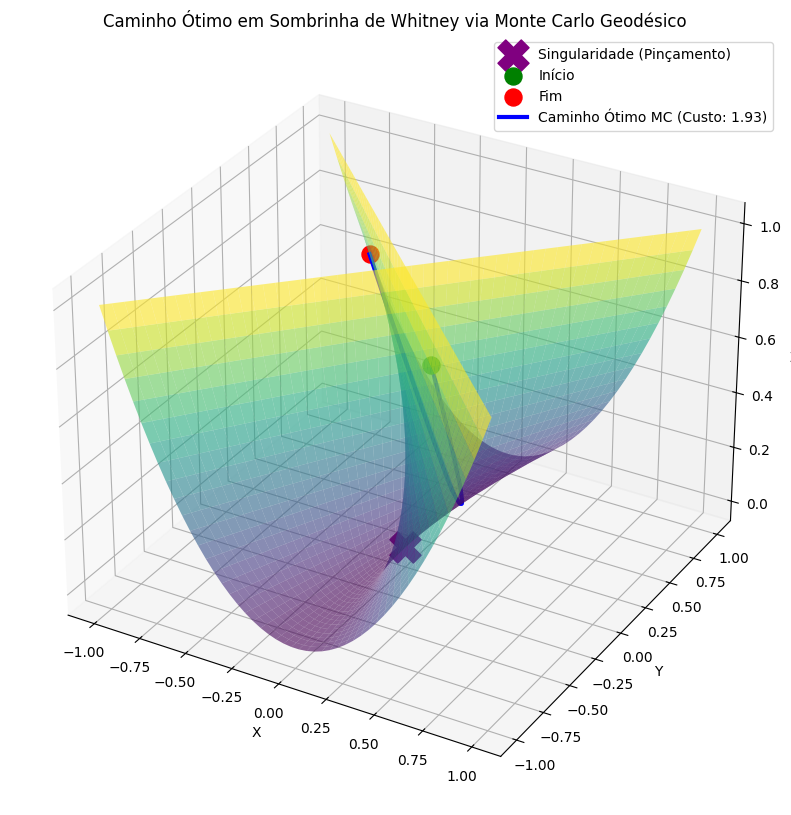

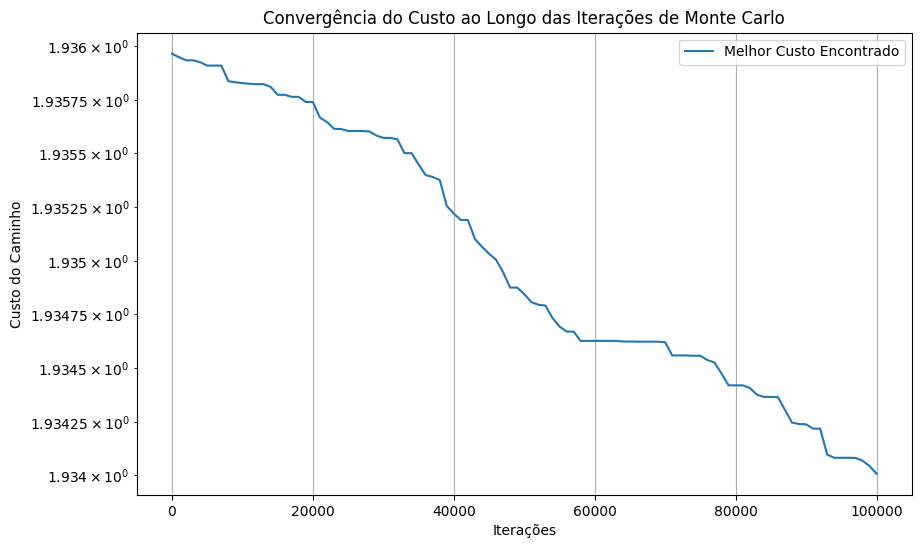

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from heapq import heappop, heappush
from scipy.optimize import minimize

# --- Habilitar interatividade (para Jupyter Notebooks/IPython, descomente a linha abaixo) ---
# %matplotlib notebook 
# Para scripts Python, pode ser necessário:
# import matplotlib
# matplotlib.use('Qt5Agg') # Ou 'TkAgg', 'WxAgg'
# import matplotlib.pyplot as plt # Importar aqui após o use()

# --- 1. Definição da Superfície: Sombrinha de Whitney ---

def whitney_umbrella_param(u, v):
    """Parametrização da Sombrinha de Whitney."""
    x = u * v
    y = u
    z = v**2
    return np.array([x, y, z])

def whitney_metric_components(u, v):
    """Calcula os componentes do tensor métrico induzido (E, F, G)."""
    E = v**2 + 1
    F = u * v
    G = u**2 + 4 * v**2
    return E, F, G

# --- 2. Definição do Potencial de Repulsão ---

epsilon_repulsion = 1e-4  # Ajuste: menor epsilon para um pico mais localizado
K_repulsion = 0.01       # Ajuste: K MUITO menor para que o custo base de 1.0 tenha peso

singularities_param = np.array([[0.0, 0.0]]) # A singularidade de pinçamento em (u,v)

def repulsion_potential(u, v, singularities, epsilon, K):
    total_repulsion = 0.0
    for su, sv in singularities:
        dist_sq = (u - su)**2 + (v - sv)**2
        total_repulsion += K / (dist_sq + epsilon)
    return total_repulsion

# --- 3. Função de Custo para um Caminho ---

def calculate_path_cost(path_uv, start_uv, end_uv, singularities, epsilon_repulsion, K_repulsion):
    """
    Calcula o custo total de um caminho no espaço de parâmetros (u,v).
    Custo = soma(comprimento_segmento * (1 + V_repulsao_no_meio_do_segmento))
    """
    num_intermediate_points = len(path_uv) // 2
    path_2d_uv = path_uv.reshape(num_intermediate_points, 2)
    full_path_uv = np.vstack([start_uv, path_2d_uv, end_uv])

    total_cost = 0.0
    for i in range(len(full_path_uv) - 1):
        p1_uv = full_path_uv[i]
        p2_uv = full_path_uv[i+1]
        
        du = p2_uv[0] - p1_uv[0]
        dv = p2_uv[1] - p1_uv[1]
        
        mid_u = (p1_uv[0] + p2_uv[0]) / 2
        mid_v = (p1_uv[1] + p2_uv[1]) / 2

        E, F, G = whitney_metric_components(mid_u, mid_v)
        
        segment_length_uv = np.sqrt(E * du**2 + 2 * F * du * dv + G * dv**2)
        
        repulsion_val = repulsion_potential(mid_u, mid_v, singularities, epsilon_repulsion, K_repulsion)
        
        cost_segment = segment_length_uv * (1.0 + repulsion_val) 
        total_cost += cost_segment
        
    return total_cost

# --- 4. Configuração do Monte Carlo Geodésico ---

start_uv = np.array([0.1, 0.8])  # Exemplo de ponto inicial (u,v)
end_uv = np.array([0.9, -0.8])  # Exemplo de ponto final (u,v)

num_intermediate_points = 50 
max_iterations = 100000       
perturb_strength = 0.05      

# --- 5. Execução do Monte Carlo Geodésico ---

initial_path_uv = np.array([np.linspace(start_uv[0], end_uv[0], num_intermediate_points + 2)[1:-1],
                            np.linspace(start_uv[1], end_uv[1], num_intermediate_points + 2)[1:-1]]).T.flatten()

best_path_uv = np.copy(initial_path_uv)
min_cost = calculate_path_cost(best_path_uv, start_uv, end_uv, singularities_param, epsilon_repulsion, K_repulsion)

cost_history = [min_cost]
iteration_count = 0

print(f"Custo inicial: {min_cost:.4f}")

for i in range(max_iterations):
    iteration_count += 1
    current_path_uv = np.copy(best_path_uv)
    
    num_perturb_points = random.randint(1, max(1, num_intermediate_points // 5)) 
    
    for _ in range(num_perturb_points):
        idx_to_perturb = random.randint(0, num_intermediate_points - 1)
        
        current_path_uv[idx_to_perturb * 2] += (random.random() - 0.5) * perturb_strength 
        current_path_uv[idx_to_perturb * 2 + 1] += (random.random() - 0.5) * perturb_strength 

        # Clampar u para ser >= 0 (para a parte comum da superfície de Whitney)
        current_path_uv[idx_to_perturb * 2] = np.clip(current_path_uv[idx_to_perturb * 2], 0.0, None)
        
    new_cost = calculate_path_cost(current_path_uv, start_uv, end_uv, singularities_param, epsilon_repulsion, K_repulsion)
    
    if new_cost < min_cost:
        min_cost = new_cost
        best_path_uv = np.copy(current_path_uv)
        
    if iteration_count % 1000 == 0:
        cost_history.append(min_cost)
        print(f"Iteração {iteration_count}, Melhor Custo: {min_cost:.4f}")

print(f"\nMonte Carlo finalizado após {max_iterations} iterações.")
print(f"Melhor Custo Final: {min_cost:.4f}")

best_path_2d_uv = best_path_uv.reshape(num_intermediate_points, 2)
full_best_path_uv = np.vstack([start_uv, best_path_2d_uv, end_uv])

best_path_xyz = np.array([whitney_umbrella_param(u, v) for u, v in full_best_path_uv])

# --- 6. Visualização 3D (agora interativa) ---

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plotar a superfície
# U_surf = np.linspace(0.01, 1, 50) # Começar um pouco acima de 0 para evitar a singularidade exata
# V_surf = np.linspace(-1, 1, 50)
# Aumentar a densidade da superfície para melhor visualização
u_surf = np.linspace(-1.0, 1.0, 50) # Cobrir mais da superfície
v_surf = np.linspace(-1.0, 1.0, 50)
U_surf, V_surf = np.meshgrid(u_surf, v_surf)
X_surf, Y_surf, Z_surf = whitney_umbrella_param(U_surf, V_surf)
ax.plot_surface(X_surf, Y_surf, Z_surf, cmap='viridis', alpha=0.6, edgecolor='none') # Maior alpha para melhor visualização

# Plotar a singularidade (0,0,0)
singularity_xyz = whitney_umbrella_param(0, 0)
ax.scatter(singularity_xyz[0], singularity_xyz[1], singularity_xyz[2], 
           color='purple', s=500, marker='X', label='Singularidade (Pinçamento)', zorder=5)

# Plotar os pontos de início e fim
start_xyz = whitney_umbrella_param(start_uv[0], start_uv[1])
end_xyz = whitney_umbrella_param(end_uv[0], end_uv[1])
ax.scatter(start_xyz[0], start_xyz[1], start_xyz[2], color='green', s=150, label='Início', zorder=4)
ax.scatter(end_xyz[0], end_xyz[1], end_xyz[2], color='red', s=150, label='Fim', zorder=4)

# Plotar o caminho encontrado
ax.plot(best_path_xyz[:, 0], best_path_xyz[:, 1], best_path_xyz[:, 2], 
        color='blue', linewidth=3, label=f'Caminho Ótimo MC (Custo: {min_cost:.2f})', zorder=3)

ax.set_title('Caminho Ótimo em Sombrinha de Whitney via Monte Carlo Geodésico')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

# --- 7. Visualização da Convergência do Custo ---

plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, max_iterations + 1, 1000), cost_history, label='Melhor Custo Encontrado')
plt.title('Convergência do Custo ao Longo das Iterações de Monte Carlo')
plt.xlabel('Iterações')
plt.ylabel('Custo do Caminho')
plt.grid(True)
plt.legend()
plt.semilogy() # Escala logarítmica no eixo Y para melhor visualização da queda de custo
plt.show()

--- Fase 1: Busca Aproximada com Monte Carlo Geodésico ---
Custo inicial (MC): 1.9360

Monte Carlo finalizado após 200000 iterações.
Melhor Custo MC Final: 1.9334

--- Fase 2: Suavização e Refinamento com Otimização Contínua ---
Otimização contínua falhou: STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT
Custo do melhor ponto encontrado pela otimização: 1.9111


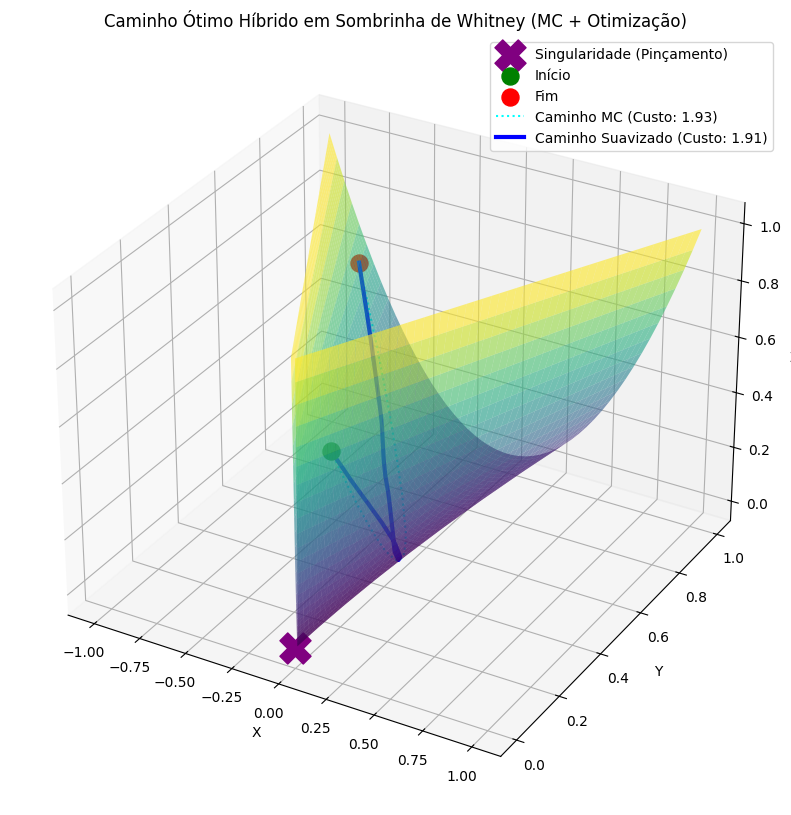

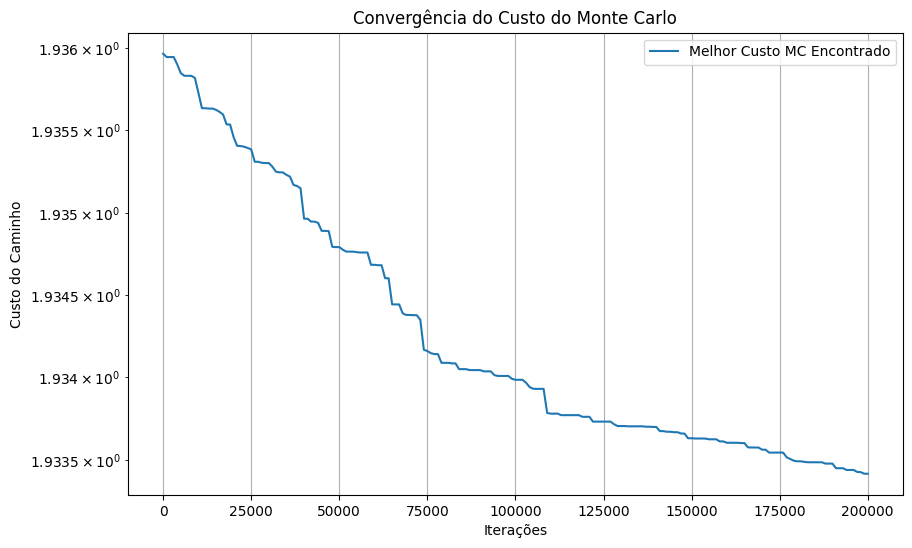

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random # Para a geração de números aleatórios
from scipy.optimize import minimize # Novo: para a otimização contínua

# --- Habilitar interatividade (para Jupyter Notebooks/IPython, descomente a linha abaixo) ---
# %matplotlib notebook 
# Para scripts Python, pode ser necessário:
# import matplotlib
# matplotlib.use('Qt5Agg') # Ou 'TkAgg', 'WxAgg'
# import matplotlib.pyplot as plt # Importar aqui após o use()

# --- 1. Definição da Superfície: Sombrinha de Whitney ---

def whitney_umbrella_param(u, v):
    """Parametrização da Sombrinha de Whitney."""
    x = u * v
    y = u
    z = v**2
    return np.array([x, y, z])

def whitney_metric_components(u, v):
    """Calcula os componentes do tensor métrico induzido (E, F, G)."""
    # r_u = (v, 1, 0)
    # r_v = (u, 0, 2v)
    
    E = v**2 + 1
    F = u * v
    G = u**2 + 4 * v**2
    return E, F, G

# --- 2. Definição do Potencial de Repulsão ---

epsilon_repulsion = 1e-4  # Ajuste: menor epsilon para um pico mais localizado
K_repulsion = 0.01       # Ajuste: K MUITO menor para que o custo base de 1.0 tenha peso

# Singularidade a evitar no espaço de parâmetros (o ponto de pinçamento)
singularities_param = np.array([[0.0, 0.0]]) 

def repulsion_potential(u, v, singularities, epsilon, K):
    total_repulsion = 0.0
    for su, sv in singularities:
        dist_sq = (u - su)**2 + (v - sv)**2
        total_repulsion += K / (dist_sq + epsilon)
    return total_repulsion

# --- 3. Função de Custo para um Caminho (agora re-usada para Monte Carlo e Otimização) ---

def calculate_path_cost(path_uv_flat_or_2d, start_uv, end_uv, singularities, epsilon_repulsion, K_repulsion):
    """
    Calcula o custo total de um caminho no espaço de parâmetros (u,v).
    Aceita path_uv_flat_or_2d: pode ser array 1D (achatado, como o otimizador precisa)
                               ou array 2D (já com inicio/fim, como o MC já faz).
    Custo = soma(comprimento_segmento * (1 + V_repulsao_no_meio_do_segmento))
    """
    
    # Adaptação: Se o path_uv_flat_or_2d for 1D (como o otimizador passa), ele contém
    # apenas os pontos intermediários e precisa ser reconstruído com start/end.
    # Se for 2D (como o MC já usa em full_best_path_uv), já tem start/end.
    if path_uv_flat_or_2d.ndim == 1:
        num_intermediate_points = len(path_uv_flat_or_2d) // 2
        path_2d_uv = path_uv_flat_or_2d.reshape(num_intermediate_points, 2)
        full_path_uv = np.vstack([start_uv, path_2d_uv, end_uv])
    else: # Já é 2D e inclui start/end (direto do MC ou path inicial)
        full_path_uv = path_uv_flat_or_2d 

    total_cost = 0.0
    for i in range(len(full_path_uv) - 1):
        p1_uv = full_path_uv[i]
        p2_uv = full_path_uv[i+1]
        
        du = p2_uv[0] - p1_uv[0]
        dv = p2_uv[1] - p1_uv[1]
        
        mid_u = (p1_uv[0] + p2_uv[0]) / 2
        mid_v = (p1_uv[1] + p2_uv[1]) / 2

        E, F, G = whitney_metric_components(mid_u, mid_v)
        
        segment_length_uv = np.sqrt(E * du**2 + 2 * F * du * dv + G * dv**2)
        
        repulsion_val = repulsion_potential(mid_u, mid_v, singularities, epsilon_repulsion, K_repulsion)
        
        cost_segment = segment_length_uv * (1.0 + repulsion_val) 
        total_cost += cost_segment
        
    return total_cost

# --- 4. Configuração do Monte Carlo Geodésico ---

start_uv = np.array([0.1, 0.8])  # Exemplo de ponto inicial (u,v)
end_uv = np.array([0.9, -0.8])  # Exemplo de ponto final (u,v)

num_intermediate_points = 50 # Número de pontos para o caminho discretizado
max_iterations = 200000       # Aumentei o número de iterações para melhor busca MC
perturb_strength = 0.05      

# --- 5. Execução do Monte Carlo Geodésico ---

print("--- Fase 1: Busca Aproximada com Monte Carlo Geodésico ---")

initial_path_uv_flat = np.array([np.linspace(start_uv[0], end_uv[0], num_intermediate_points + 2)[1:-1],
                                 np.linspace(start_uv[1], end_uv[1], num_intermediate_points + 2)[1:-1]]).T.flatten()

best_path_uv_flat_mc = np.copy(initial_path_uv_flat) # Este será o melhor chute para a otimização
min_cost_mc = calculate_path_cost(best_path_uv_flat_mc, start_uv, end_uv, singularities_param, epsilon_repulsion, K_repulsion)

cost_history = [min_cost_mc]
iteration_count = 0

print(f"Custo inicial (MC): {min_cost_mc:.4f}")

for i in range(max_iterations):
    iteration_count += 1
    current_path_uv_flat = np.copy(best_path_uv_flat_mc)
    
    num_perturb_points = random.randint(1, max(1, num_intermediate_points // 5)) 
    
    for _ in range(num_perturb_points):
        idx_to_perturb = random.randint(0, num_intermediate_points - 1)
        
        current_path_uv_flat[idx_to_perturb * 2] += (random.random() - 0.5) * perturb_strength 
        current_path_uv_flat[idx_to_perturb * 2 + 1] += (random.random() - 0.5) * perturb_strength 

        # Clampar u para ser >= 0 (para a parte comum da superfície de Whitney)
        current_path_uv_flat[idx_to_perturb * 2] = np.clip(current_path_uv_flat[idx_to_perturb * 2], 0.0, None)
        
    new_cost = calculate_path_cost(current_path_uv_flat, start_uv, end_uv, singularities_param, epsilon_repulsion, K_repulsion)
    
    if new_cost < min_cost_mc:
        min_cost_mc = new_cost
        best_path_uv_flat_mc = np.copy(current_path_uv_flat)
        
    if iteration_count % 1000 == 0:
        cost_history.append(min_cost_mc)
        # print(f"Iteração MC {iteration_count}, Melhor Custo: {min_cost_mc:.4f}") # Opcional: imprimir a cada 1000 iter.

print(f"\nMonte Carlo finalizado após {max_iterations} iterações.")
print(f"Melhor Custo MC Final: {min_cost_mc:.4f}")

# Reconstruir o melhor caminho MC para visualização (com start/end)
best_path_uv_2d_mc = best_path_uv_flat_mc.reshape(num_intermediate_points, 2)
full_best_path_uv_mc = np.vstack([start_uv, best_path_uv_2d_mc, end_uv])
best_path_xyz_mc = np.array([whitney_umbrella_param(u, v) for u, v in full_best_path_uv_mc])


# --- 6. Fase 2: Otimização Contínua com scipy.optimize.minimize ---

print("\n--- Fase 2: Suavização e Refinamento com Otimização Contínua ---")

# O chute inicial é o melhor caminho flat obtido pelo Monte Carlo
initial_guess_for_smooth = best_path_uv_flat_mc 

# Definir limites para as coordenadas (u,v). Assumimos que u>=0 e v entre -1 e 1
bounds_optimizer = []
for i in range(len(initial_guess_for_smooth) // 2):
    # u-coordinate (index 2*i) -> should be >= 0. Could limit to 1.0 as well.
    bounds_optimizer.append((0.0, 1.0)) # Let's say u can go up to 1.0 for now
    # v-coordinate (index 2*i + 1) -> typical range [-1.0, 1.0] for Whitney
    bounds_optimizer.append((-1.0, 1.0)) 

try:
    res = minimize(calculate_path_cost, initial_guess_for_smooth, 
                   args=(start_uv, end_uv, singularities_param, epsilon_repulsion, K_repulsion), 
                   method='L-BFGS-B', 
                   bounds=bounds_optimizer,
                   options={'maxiter': 5000, 'disp': True, 'ftol': 1e-7})

    if res.success:
        print(f"Otimização contínua bem-sucedida! Custo final: {res.fun:.4f}")
        optimized_intermediate_points_uv_flat = res.x
        
    else:
        print(f"Otimização contínua falhou: {res.message}")
        print(f"Custo do melhor ponto encontrado pela otimização: {res.fun:.4f}")
        optimized_intermediate_points_uv_flat = res.x # Mesmo se falhar, use o melhor ponto encontrado
        
except Exception as e:
    print(f"Erro inesperado durante a otimização contínua: {e}")
    # Se a otimização contínua falhar completamente, reverter para o caminho MC
    optimized_intermediate_points_uv_flat = best_path_uv_flat_mc
    print("Revertendo para o caminho encontrado pelo Monte Carlo.")


# Reconstruir o caminho otimizado final para visualização
optimized_intermediate_points_uv_2d = optimized_intermediate_points_uv_flat.reshape(num_intermediate_points, 2)
final_smooth_path_uv = np.vstack([start_uv, optimized_intermediate_points_uv_2d, end_uv])
final_smooth_path_xyz = np.array([whitney_umbrella_param(u, v) for u, v in final_smooth_path_uv])
final_cost_smooth = calculate_path_cost(final_smooth_path_uv, start_uv, end_uv, singularities_param, epsilon_repulsion, K_repulsion)

# --- 7. Visualização 3D (agora com ambos os caminhos) ---

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plotar a superfície
u_surf = np.linspace(0.01, 1.0, 50) 
v_surf = np.linspace(-1.0, 1.0, 50) # V vai de -1 a 1 para mostrar ambas as folhas
U_surf, V_surf = np.meshgrid(u_surf, v_surf)
X_surf, Y_surf, Z_surf = whitney_umbrella_param(U_surf, V_surf)
ax.plot_surface(X_surf, Y_surf, Z_surf, cmap='viridis', alpha=0.6, edgecolor='none') 

# Plotar a singularidade (0,0,0)
singularity_xyz = whitney_umbrella_param(0, 0)
ax.scatter(singularity_xyz[0], singularity_xyz[1], singularity_xyz[2], 
           color='purple', s=500, marker='X', label='Singularidade (Pinçamento)', zorder=5)

# Plotar os pontos de início e fim
start_xyz = whitney_umbrella_param(start_uv[0], start_uv[1])
end_xyz = whitney_umbrella_param(end_uv[0], end_uv[1])
ax.scatter(start_xyz[0], start_xyz[1], start_xyz[2], color='green', s=150, label='Início', zorder=4)
ax.scatter(end_xyz[0], end_xyz[1], end_xyz[2], color='red', s=150, label='Fim', zorder=4)

# Plotar o caminho MC (discreto)
ax.plot(best_path_xyz_mc[:, 0], best_path_xyz_mc[:, 1], best_path_xyz_mc[:, 2], 
        color='cyan', linestyle=':', linewidth=1.5, label=f'Caminho MC (Custo: {min_cost_mc:.2f})', zorder=2)

# Plotar o caminho suavizado (pós-otimização)
ax.plot(final_smooth_path_xyz[:, 0], final_smooth_path_xyz[:, 1], final_smooth_path_xyz[:, 2], 
        color='blue', linewidth=3, label=f'Caminho Suavizado (Custo: {final_cost_smooth:.2f})', zorder=3)

ax.set_title('Caminho Ótimo Híbrido em Sombrinha de Whitney (MC + Otimização)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

# --- 8. Visualização da Convergência do Custo (apenas MC) ---

plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, max_iterations + 1, 1000), cost_history, label='Melhor Custo MC Encontrado')
plt.title('Convergência do Custo do Monte Carlo')
plt.xlabel('Iterações')
plt.ylabel('Custo do Caminho')
plt.grid(True)
plt.legend()
plt.semilogy() 
plt.show()

--- Fase 1: Busca Aproximada com Monte Carlo Geodésico ---
Custo inicial (MC): 16.3619
Iteração MC 5000, Melhor Custo: 8.7628
Iteração MC 10000, Melhor Custo: 8.2679
Iteração MC 15000, Melhor Custo: 7.8043
Iteração MC 20000, Melhor Custo: 7.6397
Iteração MC 25000, Melhor Custo: 7.4006
Iteração MC 30000, Melhor Custo: 7.2865
Iteração MC 35000, Melhor Custo: 7.2332
Iteração MC 40000, Melhor Custo: 7.1954
Iteração MC 45000, Melhor Custo: 7.1812
Iteração MC 50000, Melhor Custo: 7.1080
Iteração MC 55000, Melhor Custo: 7.0744
Iteração MC 60000, Melhor Custo: 7.0600
Iteração MC 65000, Melhor Custo: 7.0339
Iteração MC 70000, Melhor Custo: 7.0247
Iteração MC 75000, Melhor Custo: 6.9775
Iteração MC 80000, Melhor Custo: 6.9484
Iteração MC 85000, Melhor Custo: 6.9310
Iteração MC 90000, Melhor Custo: 6.9013
Iteração MC 95000, Melhor Custo: 6.8769
Iteração MC 100000, Melhor Custo: 6.8605
Iteração MC 105000, Melhor Custo: 6.8494
Iteração MC 110000, Melhor Custo: 6.8324
Iteração MC 115000, Melhor Cust

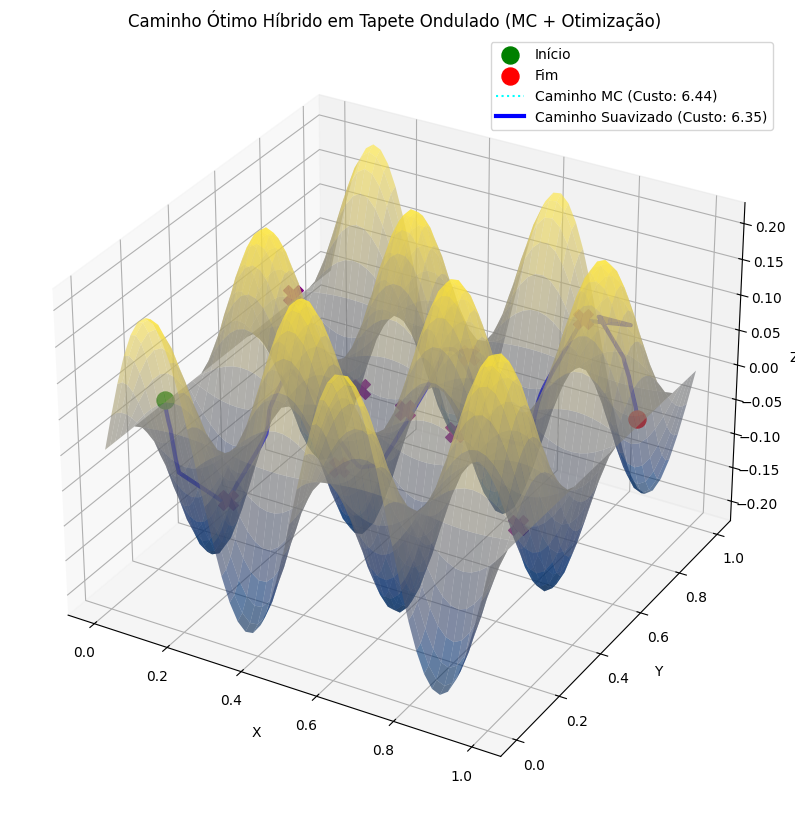

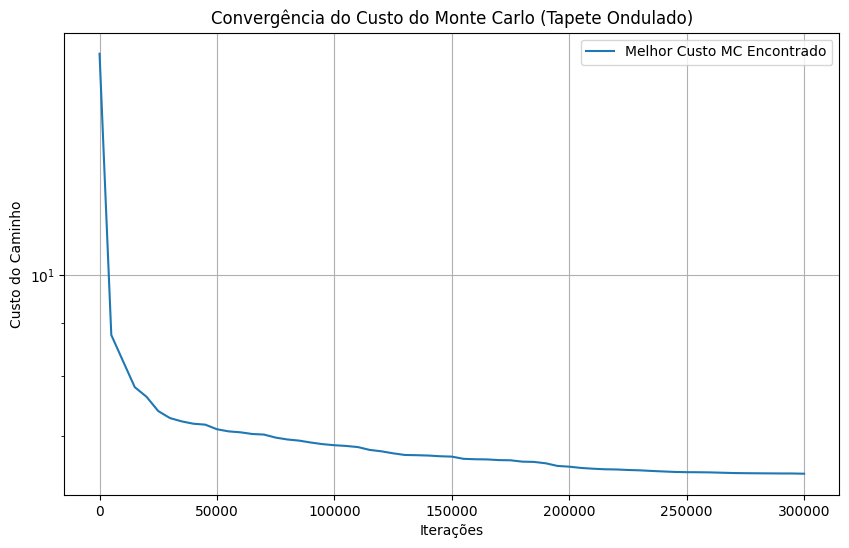

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from scipy.optimize import minimize

# --- Habilitar interatividade ---
# %matplotlib notebook 
# Ou para scripts:
# import matplotlib
# matplotlib.use('Qt5Agg') # Requer pip install PyQt5
# import matplotlib.pyplot as plt

# --- 1. Definição da NOVA Superfície: Tapete Ondulado ---

AMPLITUDE = 0.2
FREQ_U = 4.0 * np.pi
FREQ_V = 4.0 * np.pi

def wavy_surface_param(u, v):
    """Parametrização do Tapete Ondulado."""
    x = u
    y = v
    z = AMPLITUDE * np.sin(FREQ_U * u) * np.cos(FREQ_V * v)
    return np.array([x, y, z])

def wavy_surface_metric_components(u, v):
    """Calcula os componentes do tensor métrico induzido (E, F, G) para o Tapete Ondulado."""
    # r_u = (dx/du, dy/du, dz/du)
    # r_v = (dx/dv, dy/dv, dz/dv)
    
    dz_du = AMPLITUDE * FREQ_U * np.cos(FREQ_U * u) * np.cos(FREQ_V * v)
    dz_dv = -AMPLITUDE * FREQ_V * np.sin(FREQ_U * u) * np.sin(FREQ_V * v)
    
    r_u = np.array([1.0, 0.0, dz_du])
    r_v = np.array([0.0, 1.0, dz_dv])
    
    E = np.dot(r_u, r_u)
    F = np.dot(r_u, r_v)
    G = np.dot(r_v, r_v)
    
    return E, F, G

# --- 2. Definição do Potencial de Repulsão ---

epsilon_repulsion = 1e-4 # Raio de influência da penalidade
K_repulsion = 0.01       # Força da penalidade (ajuste fino aqui!)

# Múltiplas "singularidades" no espaço de parâmetros (u,v)
singularities_param = np.array([
    [0.2, 0.2], [0.2, 0.5], [0.2, 0.8],
    [0.5, 0.2], [0.5, 0.5], [0.5, 0.8],
    [0.8, 0.2], [0.8, 0.5], [0.8, 0.8]
])

def repulsion_potential(u, v, singularities, epsilon, K):
    total_repulsion = 0.0
    for su, sv in singularities:
        dist_sq = (u - su)**2 + (v - sv)**2
        total_repulsion += K / (dist_sq + epsilon)
    return total_repulsion

# --- 3. Função de Custo para um Caminho ---

def calculate_path_cost(path_uv_flat_or_2d, start_uv, end_uv, singularities, epsilon_repulsion, K_repulsion):
    """
    Calcula o custo total de um caminho no espaço de parâmetros (u,v) na nova superfície.
    """
    if path_uv_flat_or_2d.ndim == 1:
        num_intermediate_points = len(path_uv_flat_or_2d) // 2
        path_2d_uv = path_uv_flat_or_2d.reshape(num_intermediate_points, 2)
        full_path_uv = np.vstack([start_uv, path_2d_uv, end_uv])
    else: 
        full_path_uv = path_uv_flat_or_2d 

    total_cost = 0.0
    for i in range(len(full_path_uv) - 1):
        p1_uv = full_path_uv[i]
        p2_uv = full_path_uv[i+1]
        
        du = p2_uv[0] - p1_uv[0]
        dv = p2_uv[1] - p1_uv[1]
        
        mid_u = (p1_uv[0] + p2_uv[0]) / 2
        mid_v = (p1_uv[1] + p2_uv[1]) / 2

        # Usar os componentes da métrica da NOVA SUPERFÍCIE
        E, F, G = wavy_surface_metric_components(mid_u, mid_v)
        
        segment_length_uv = np.sqrt(E * du**2 + 2 * F * du * dv + G * dv**2)
        
        repulsion_val = repulsion_potential(mid_u, mid_v, singularities, epsilon_repulsion, K_repulsion)
        
        cost_segment = segment_length_uv * (1.0 + repulsion_val) 
        total_cost += cost_segment
        
    return total_cost

# --- 4. Configuração do Monte Carlo Geodésico ---

start_uv = np.array([0.1, 0.1])  # Ponto inicial no (u,v)
end_uv = np.array([0.9, 0.9])    # Ponto final no (u,v)

num_intermediate_points = 100 # Aumentar para melhor discretização
max_iterations = 300000       # Mais iterações para superfícies complexas
perturb_strength = 0.02      # Força de perturbação

# --- 5. Execução do Monte Carlo Geodésico ---

print("--- Fase 1: Busca Aproximada com Monte Carlo Geodésico ---")

initial_path_uv_flat = np.array([np.linspace(start_uv[0], end_uv[0], num_intermediate_points + 2)[1:-1],
                                 np.linspace(start_uv[1], end_uv[1], num_intermediate_points + 2)[1:-1]]).T.flatten()

best_path_uv_flat_mc = np.copy(initial_path_uv_flat) 
min_cost_mc = calculate_path_cost(best_path_uv_flat_mc, start_uv, end_uv, singularities_param, epsilon_repulsion, K_repulsion)

cost_history = [min_cost_mc]
iteration_count = 0

print(f"Custo inicial (MC): {min_cost_mc:.4f}")

for i in range(max_iterations):
    iteration_count += 1
    current_path_uv_flat = np.copy(best_path_uv_flat_mc)
    
    num_perturb_points = random.randint(1, max(1, num_intermediate_points // 10)) # Perturbar menos pontos por vez
    
    for _ in range(num_perturb_points):
        idx_to_perturb = random.randint(0, num_intermediate_points - 1)
        
        current_path_uv_flat[idx_to_perturb * 2] += (random.random() - 0.5) * perturb_strength 
        current_path_uv_flat[idx_to_perturb * 2 + 1] += (random.random() - 0.5) * perturb_strength 

        # Clampar as coordenadas u e v para o domínio da superfície [0, 1]
        current_path_uv_flat[idx_to_perturb * 2] = np.clip(current_path_uv_flat[idx_to_perturb * 2], 0.0, 1.0)
        current_path_uv_flat[idx_to_perturb * 2 + 1] = np.clip(current_path_uv_flat[idx_to_perturb * 2 + 1], 0.0, 1.0)
        
    new_cost = calculate_path_cost(current_path_uv_flat, start_uv, end_uv, singularities_param, epsilon_repulsion, K_repulsion)
    
    if new_cost < min_cost_mc:
        min_cost_mc = new_cost
        best_path_uv_flat_mc = np.copy(current_path_uv_flat)
        
    if iteration_count % 5000 == 0: # Imprimir com menos frequência para muitas iterações
        cost_history.append(min_cost_mc)
        print(f"Iteração MC {iteration_count}, Melhor Custo: {min_cost_mc:.4f}") 

print(f"\nMonte Carlo finalizado após {max_iterations} iterações.")
print(f"Melhor Custo MC Final: {min_cost_mc:.4f}")

best_path_uv_2d_mc = best_path_uv_flat_mc.reshape(num_intermediate_points, 2)
full_best_path_uv_mc = np.vstack([start_uv, best_path_uv_2d_mc, end_uv])
# Mapear para XYZ usando a NOVA PARAMETRIZAÇÃO
best_path_xyz_mc = np.array([wavy_surface_param(u, v) for u, v in full_best_path_uv_mc])


# --- 6. Fase 2: Otimização Contínua com scipy.optimize.minimize ---

print("\n--- Fase 2: Suavização e Refinamento com Otimização Contínua ---")

initial_guess_for_smooth = best_path_uv_flat_mc 

# Definir limites para as coordenadas (u,v) - assumindo domínio [0,1]x[0,1]
bounds_optimizer = []
for _ in range(len(initial_guess_for_smooth) // 2):
    bounds_optimizer.append((0.0, 1.0)) # Limite para u
    bounds_optimizer.append((0.0, 1.0)) # Limite para v

try:
    res = minimize(calculate_path_cost, initial_guess_for_smooth, 
                   args=(start_uv, end_uv, singularities_param, epsilon_repulsion, K_repulsion), 
                   method='L-BFGS-B', 
                   bounds=bounds_optimizer,
                   options={'maxiter': 5000, 'disp': True, 'ftol': 1e-7})

    if res.success:
        print(f"Otimização contínua bem-sucedida! Custo final: {res.fun:.4f}")
        optimized_intermediate_points_uv_flat = res.x
        
    else:
        print(f"Otimização contínua falhou: {res.message}")
        print(f"Custo do melhor ponto encontrado pela otimização: {res.fun:.4f}")
        optimized_intermediate_points_uv_flat = res.x 
        
except Exception as e:
    print(f"Erro inesperado durante a otimização contínua: {e}")
    optimized_intermediate_points_uv_flat = best_path_uv_flat_mc
    print("Revertendo para o caminho encontrado pelo Monte Carlo.")


optimized_intermediate_points_uv_2d = optimized_intermediate_points_uv_flat.reshape(num_intermediate_points, 2)
final_smooth_path_uv = np.vstack([start_uv, optimized_intermediate_points_uv_2d, end_uv])
# Mapear para XYZ usando a NOVA PARAMETRIZAÇÃO
final_smooth_path_xyz = np.array([wavy_surface_param(u, v) for u, v in final_smooth_path_uv])
final_cost_smooth = calculate_path_cost(final_smooth_path_uv, start_uv, end_uv, singularities_param, epsilon_repulsion, K_repulsion)

# --- 7. Visualização 3D ---

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plotar a NOVA SUPERFÍCIE
u_surf_plot = np.linspace(0.0, 1.0, 50) 
v_surf_plot = np.linspace(0.0, 1.0, 50) 
U_surf_plot, V_surf_plot = np.meshgrid(u_surf_plot, v_surf_plot)
X_surf_plot, Y_surf_plot, Z_surf_plot = wavy_surface_param(U_surf_plot, V_surf_plot)
ax.plot_surface(X_surf_plot, Y_surf_plot, Z_surf_plot, cmap='cividis', alpha=0.6, edgecolor='none') 

# Plotar os pontos de penalidade no espaço (x,y,z) mapeado
for su, sv in singularities_param:
    sx, sy, sz = wavy_surface_param(su, sv)
    ax.scatter(sx, sy, sz, color='purple', s=200, marker='X', zorder=5) # Menor size para visibilidade

# Plotar os pontos de início e fim
start_xyz = wavy_surface_param(start_uv[0], start_uv[1])
end_xyz = wavy_surface_param(end_uv[0], end_uv[1])
ax.scatter(start_xyz[0], start_xyz[1], start_xyz[2], color='green', s=150, label='Início', zorder=4)
ax.scatter(end_xyz[0], end_xyz[1], end_xyz[2], color='red', s=150, label='Fim', zorder=4)

# Plotar o caminho MC (discreto)
ax.plot(best_path_xyz_mc[:, 0], best_path_xyz_mc[:, 1], best_path_xyz_mc[:, 2], 
        color='cyan', linestyle=':', linewidth=1.5, label=f'Caminho MC (Custo: {min_cost_mc:.2f})', zorder=2)

# Plotar o caminho suavizado (pós-otimização)
ax.plot(final_smooth_path_xyz[:, 0], final_smooth_path_xyz[:, 1], final_smooth_path_xyz[:, 2], 
        color='blue', linewidth=3, label=f'Caminho Suavizado (Custo: {final_cost_smooth:.2f})', zorder=3)

ax.set_title('Caminho Ótimo Híbrido em Tapete Ondulado (MC + Otimização)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

# --- 8. Visualização da Convergência do Custo (apenas MC) ---

plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, max_iterations + 1, 5000), cost_history, label='Melhor Custo MC Encontrado')
plt.title('Convergência do Custo do Monte Carlo (Tapete Ondulado)')
plt.xlabel('Iterações')
plt.ylabel('Custo do Caminho')
plt.grid(True)
plt.legend()
plt.semilogy() 
plt.show()

In [1]:
import numpy as np
import matplotlib
# A linha abaixo deve ser executada ANTES de 'import matplotlib.pyplot as plt'
matplotlib.use('Qt5Agg') # Tenta usar Qt5 para renderização interativa.
                         # Você pode precisar de: pip install PyQt5
                         # Alternativa (se PyQt não funcionar): matplotlib.use('TkAgg')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from scipy.optimize import minimize

# Para Jupyter Notebooks / IPython, use uma das linhas abaixo no início da célula:
# %matplotlib notebook   # Para interatividade dentro do notebook
# %matplotlib qt         # Para abrir uma janela separada (requer PyQt5/6)


# --- 1. Definição da NOVA Superfície: Tapete Ondulado ---

AMPLITUDE = 0.2
FREQ_U = 4.0 * np.pi
FREQ_V = 4.0 * np.pi

def wavy_surface_param(u, v):
    """Parametrização do Tapete Ondulado."""
    x = u
    y = v
    z = AMPLITUDE * np.sin(FREQ_U * u) * np.cos(FREQ_V * v)
    return np.array([x, y, z])

def wavy_surface_metric_components(u, v):
    """Calcula os componentes do tensor métrico induzido (E, F, G) para o Tapete Ondulado."""
    dz_du = AMPLITUDE * FREQ_U * np.cos(FREQ_U * u) * np.cos(FREQ_V * v)
    dz_dv = -AMPLITUDE * FREQ_V * np.sin(FREQ_U * u) * np.sin(FREQ_V * v)
    
    r_u = np.array([1.0, 0.0, dz_du])
    r_v = np.array([0.0, 1.0, dz_dv])
    
    E = np.dot(r_u, r_u)
    F = np.dot(r_u, r_v)
    G = np.dot(r_v, r_v)
    
    return E, F, G

# --- 2. Definição do Potencial de Repulsão ---

epsilon_repulsion = 1e-4 
K_repulsion = 0.01       

# Múltiplas "singularidades" no espaço de parâmetros (u,v)
singularities_param = np.array([
    [0.2, 0.2], [0.2, 0.5], [0.2, 0.8],
    [0.5, 0.2], [0.5, 0.5], [0.5, 0.8],
    [0.8, 0.2], [0.8, 0.5], [0.8, 0.8]
])

def repulsion_potential(u, v, singularities, epsilon, K):
    total_repulsion = 0.0
    for su, sv in singularities:
        dist_sq = (u - su)**2 + (v - sv)**2
        total_repulsion += K / (dist_sq + epsilon)
    return total_repulsion

# --- 3. Função de Custo para um Caminho ---

def calculate_path_cost(path_uv_flat_or_2d, start_uv, end_uv, singularities, epsilon_repulsion, K_repulsion):
    """
    Calcula o custo total de um caminho no espaço de parâmetros (u,v) na nova superfície.
    """
    if path_uv_flat_or_2d.ndim == 1:
        num_intermediate_points = len(path_uv_flat_or_2d) // 2
        path_2d_uv = path_uv_flat_or_2d.reshape(num_intermediate_points, 2)
        full_path_uv = np.vstack([start_uv, path_2d_uv, end_uv])
    else: 
        full_path_uv = path_uv_flat_or_2d 

    total_cost = 0.0
    for i in range(len(full_path_uv) - 1):
        p1_uv = full_path_uv[i]
        p2_uv = full_path_uv[i+1]
        
        du = p2_uv[0] - p1_uv[0]
        dv = p2_uv[1] - p1_uv[1]
        
        mid_u = (p1_uv[0] + p2_uv[0]) / 2
        mid_v = (p1_uv[1] + p2_uv[1]) / 2

        E, F, G = wavy_surface_metric_components(mid_u, mid_v)
        
        segment_length_uv = np.sqrt(E * du**2 + 2 * F * du * dv + G * dv**2)
        
        repulsion_val = repulsion_potential(mid_u, mid_v, singularities, epsilon_repulsion, K_repulsion)
        
        cost_segment = segment_length_uv * (1.0 + repulsion_val) 
        total_cost += cost_segment
        
    return total_cost

# --- 4. Configuração do Monte Carlo Geodésico ---

start_uv = np.array([0.1, 0.1]) 
end_uv = np.array([0.9, 0.9])    

num_intermediate_points = 100 
max_iterations = 300000       
perturb_strength = 0.02      

# --- 5. Execução do Monte Carlo Geodésico ---

print("--- Fase 1: Busca Aproximada com Monte Carlo Geodésico ---")

initial_path_uv_flat = np.array([np.linspace(start_uv[0], end_uv[0], num_intermediate_points + 2)[1:-1],
                                 np.linspace(start_uv[1], end_uv[1], num_intermediate_points + 2)[1:-1]]).T.flatten()

best_path_uv_flat_mc = np.copy(initial_path_uv_flat) 
min_cost_mc = calculate_path_cost(best_path_uv_flat_mc, start_uv, end_uv, singularities_param, epsilon_repulsion, K_repulsion)

cost_history = [min_cost_mc]
iteration_count = 0

print(f"Custo inicial (MC): {min_cost_mc:.4f}")

for i in range(max_iterations):
    iteration_count += 1
    current_path_uv_flat = np.copy(best_path_uv_flat_mc)
    
    num_perturb_points = random.randint(1, max(1, num_intermediate_points // 10)) 
    
    for _ in range(num_perturb_points):
        idx_to_perturb = random.randint(0, num_intermediate_points - 1)
        
        current_path_uv_flat[idx_to_perturb * 2] += (random.random() - 0.5) * perturb_strength 
        current_path_uv_flat[idx_to_perturb * 2 + 1] += (random.random() - 0.5) * perturb_strength 

        current_path_uv_flat[idx_to_perturb * 2] = np.clip(current_path_uv_flat[idx_to_perturb * 2], 0.0, 1.0)
        current_path_uv_flat[idx_to_perturb * 2 + 1] = np.clip(current_path_uv_flat[idx_to_perturb * 2 + 1], 0.0, 1.0)
        
    new_cost = calculate_path_cost(current_path_uv_flat, start_uv, end_uv, singularities_param, epsilon_repulsion, K_repulsion)
    
    if new_cost < min_cost_mc:
        min_cost_mc = new_cost
        best_path_uv_flat_mc = np.copy(current_path_uv_flat)
        
    if iteration_count % 5000 == 0: 
        cost_history.append(min_cost_mc)
        print(f"Iteração MC {iteration_count}, Melhor Custo: {min_cost_mc:.4f}") 

print(f"\nMonte Carlo finalizado após {max_iterations} iterações.")
print(f"Melhor Custo MC Final: {min_cost_mc:.4f}")

best_path_uv_2d_mc = best_path_uv_flat_mc.reshape(num_intermediate_points, 2)
full_best_path_uv_mc = np.vstack([start_uv, best_path_uv_2d_mc, end_uv])
best_path_xyz_mc = np.array([wavy_surface_param(u, v) for u, v in full_best_path_uv_mc])


# --- 6. Fase 2: Otimização Contínua com scipy.optimize.minimize ---

print("\n--- Fase 2: Suavização e Refinamento com Otimização Contínua ---")

initial_guess_for_smooth = best_path_uv_flat_mc 

bounds_optimizer = []
for _ in range(len(initial_guess_for_smooth) // 2):
    bounds_optimizer.append((0.0, 1.0)) 
    bounds_optimizer.append((0.0, 1.0)) 

try:
    res = minimize(calculate_path_cost, initial_guess_for_smooth, 
                   args=(start_uv, end_uv, singularities_param, epsilon_repulsion, K_repulsion), 
                   method='L-BFGS-B', 
                   bounds=bounds_optimizer,
                   options={'maxiter': 5000, 'disp': True, 'ftol': 1e-7})

    if res.success:
        print(f"Otimização contínua bem-sucedida! Custo final: {res.fun:.4f}")
        optimized_intermediate_points_uv_flat = res.x
        
    else:
        print(f"Otimização contínua falhou: {res.message}")
        print(f"Custo do melhor ponto encontrado pela otimização: {res.fun:.4f}")
        optimized_intermediate_points_uv_flat = res.x 
        
except Exception as e:
    print(f"Erro inesperado durante a otimização contínua: {e}")
    optimized_intermediate_points_uv_flat = best_path_uv_flat_mc
    print("Revertendo para o caminho encontrado pelo Monte Carlo.")


optimized_intermediate_points_uv_2d = optimized_intermediate_points_uv_flat.reshape(num_intermediate_points, 2)
final_smooth_path_uv = np.vstack([start_uv, optimized_intermediate_points_uv_2d, end_uv])
final_smooth_path_xyz = np.array([wavy_surface_param(u, v) for u, v in final_smooth_path_uv])
final_cost_smooth = calculate_path_cost(final_smooth_path_uv, start_uv, end_uv, singularities_param, epsilon_repulsion, K_repulsion)

# --- 7. Visualização 3D ---

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plotar a NOVA SUPERFÍCIE
u_surf_plot = np.linspace(0.0, 1.0, 50) 
v_surf_plot = np.linspace(0.0, 1.0, 50) 
U_surf_plot, V_surf_plot = np.meshgrid(u_surf_plot, v_surf_plot)
X_surf_plot, Y_surf_plot, Z_surf_plot = wavy_surface_param(U_surf_plot, V_surf_plot)
ax.plot_surface(X_surf_plot, Y_surf_plot, Z_surf_plot, cmap='cividis', alpha=0.6, edgecolor='none') 

# Plotar os pontos de penalidade no espaço (x,y,z) mapeado
for su, sv in singularities_param:
    sx, sy, sz = wavy_surface_param(su, sv)
    ax.scatter(sx, sy, sz, color='purple', s=200, marker='X', zorder=5) 

# Plotar os pontos de início e fim
start_xyz = wavy_surface_param(start_uv[0], start_uv[1])
end_xyz = wavy_surface_param(end_uv[0], end_uv[1])
ax.scatter(start_xyz[0], start_xyz[1], start_xyz[2], color='green', s=150, label='Início', zorder=4)
ax.scatter(end_xyz[0], end_xyz[1], end_xyz[2], color='red', s=150, label='Fim', zorder=4)

# Plotar o caminho MC (discreto)
ax.plot(best_path_xyz_mc[:, 0], best_path_xyz_mc[:, 1], best_path_xyz_mc[:, 2], 
        color='cyan', linestyle=':', linewidth=1.5, label=f'Caminho MC (Custo: {min_cost_mc:.2f})', zorder=2)

# Plotar o caminho suavizado (pós-otimização)
ax.plot(final_smooth_path_xyz[:, 0], final_smooth_path_xyz[:, 1], final_smooth_path_xyz[:, 2], 
        color='blue', linewidth=3, label=f'Caminho Suavizado (Custo: {final_cost_smooth:.2f})', zorder=3)

ax.set_title('Caminho Ótimo Híbrido em Tapete Ondulado (MC + Otimização)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show() # Esta linha abre a janela e mantém o programa esperando por interatividade.

# --- 8. Visualização da Convergência do Custo (apenas MC) ---

plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, max_iterations + 1, 5000), cost_history, label='Melhor Custo MC Encontrado')
plt.title('Convergência do Custo do Monte Carlo (Tapete Ondulado)')
plt.xlabel('Iterações')
plt.ylabel('Custo do Caminho')
plt.grid(True)
plt.legend()
plt.semilogy() 
plt.show()

--- Fase 1: Busca Aproximada com Monte Carlo Geodésico ---
Custo inicial (MC): 16.3619
Iteração MC 5000, Melhor Custo: 9.2124
Iteração MC 10000, Melhor Custo: 7.8603
Iteração MC 15000, Melhor Custo: 7.4467
Iteração MC 20000, Melhor Custo: 7.2216
Iteração MC 25000, Melhor Custo: 7.0689
Iteração MC 30000, Melhor Custo: 6.9239
Iteração MC 35000, Melhor Custo: 6.8684
Iteração MC 40000, Melhor Custo: 6.8260
Iteração MC 45000, Melhor Custo: 6.7448
Iteração MC 50000, Melhor Custo: 6.7146
Iteração MC 55000, Melhor Custo: 6.6748
Iteração MC 60000, Melhor Custo: 6.6127
Iteração MC 65000, Melhor Custo: 6.5685
Iteração MC 70000, Melhor Custo: 6.5453
Iteração MC 75000, Melhor Custo: 6.5212
Iteração MC 80000, Melhor Custo: 6.4991
Iteração MC 85000, Melhor Custo: 6.4638
Iteração MC 90000, Melhor Custo: 6.4492
Iteração MC 95000, Melhor Custo: 6.4333
Iteração MC 100000, Melhor Custo: 6.4082
Iteração MC 105000, Melhor Custo: 6.3990
Iteração MC 110000, Melhor Custo: 6.3908
Iteração MC 115000, Melhor Cust

KeyboardInterrupt: 

In [5]:
import numpy as np
import matplotlib
# A linha abaixo deve ser executada ANTES de 'import matplotlib.pyplot as plt'
# IMPORTANTE: A rotação depende do seu ambiente e instalação. 
# Se PyQt5/6 estiver instalado, descomente 'Qt5Agg' ou 'Qt6Agg'.
# Se não, pode tentar 'TkAgg' (geralmente padrão do Python, mas pode ser menos robusto para 3D).
# matplotlib.use('Qt5Agg') 

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from scipy.optimize import minimize, root # Import 'root' for the DVI solver
import matplotlib.cbook # For numerical jacobian

# --- Surface Definitions (Tapete Ondulado) ---
AMPLITUDE = 0.2
FREQ_U = 4.0 * np.pi
FREQ_V = 4.0 * np.pi

def wavy_surface_param(u, v):
    x = u
    y = v
    z = AMPLITUDE * np.sin(FREQ_U * u) * np.cos(FREQ_V * v)
    return np.array([x, y, z])

def wavy_surface_metric_components(u, v):
    dz_du = AMPLITUDE * FREQ_U * np.cos(FREQ_U * u) * np.cos(FREQ_V * v)
    dz_dv = -AMPLITUDE * FREQ_V * np.sin(FREQ_U * u) * np.sin(FREQ_V * v)
    r_u = np.array([1.0, 0.0, dz_du])
    r_v = np.array([0.0, 1.0, dz_dv])
    E = np.dot(r_u, r_u)
    F = np.dot(r_u, r_v)
    G = np.dot(r_v, r_v)
    return E, F, G

# --- Repulsion Potential ---
epsilon_repulsion = 1e-4 
K_repulsion = 0.01       

singularities_param = np.array([
    [0.2, 0.2], [0.2, 0.5], [0.2, 0.8],
    [0.5, 0.2], [0.5, 0.5], [0.5, 0.8],
    [0.8, 0.2], [0.8, 0.5], [0.8, 0.8]
])

def repulsion_potential(u, v, singularities, epsilon, K):
    total_repulsion = 0.0
    for su, sv in singularities:
        dist_sq = (u - su)**2 + (v - sv)**2
        total_repulsion += K / (dist_sq + epsilon)
    return total_repulsion

# --- Cost Calculation for an entire path (used by MC and for final cost calc) ---
def calculate_path_cost(path_uv_flat_or_2d, start_uv, end_uv, singularities, epsilon_repulsion, K_repulsion):
    if path_uv_flat_or_2d.ndim == 1:
        num_intermediate_points = len(path_uv_flat_or_2d) // 2
        path_2d_uv = path_uv_flat_or_2d.reshape(num_intermediate_points, 2)
        full_path_uv = np.vstack([start_uv, path_2d_uv, end_uv])
    else: 
        full_path_uv = path_uv_flat_or_2d 

    total_cost = 0.0
    for i in range(len(full_path_uv) - 1):
        p1_uv = full_path_uv[i]
        p2_uv = full_path_uv[i+1]
        
        du = p2_uv[0] - p1_uv[0]
        dv = p2_uv[1] - p1_uv[1]
        
        mid_u = (p1_uv[0] + p2_uv[0]) / 2
        mid_v = (p1_uv[1] + p2_uv[1]) / 2

        E, F, G = wavy_surface_metric_components(mid_u, mid_v)
        segment_length_uv = np.sqrt(E * du**2 + 2 * F * du * dv + G * dv**2)
        repulsion_val = repulsion_potential(mid_u, mid_v, singularities, epsilon_repulsion, K_repulsion)
        cost_segment = segment_length_uv * (1.0 + repulsion_val) 
        total_cost += cost_segment
        
    return total_cost

# --- NEW: DVI Specific Functions ---

# 1. Helper function: Discrete Lagrangian for a single segment (Ld(qk, qkp1))
def get_segment_Ld_value(q_k_uv, q_kp1_uv, singularities, epsilon_repulsion, K_repulsion):
    """Calculates the discrete Lagrangian L_d for a single segment."""
    
    du = q_kp1_uv[0] - q_k_uv[0]
    dv = q_kp1_uv[1] - q_k_uv[1]
    
    mid_u = (q_k_uv[0] + q_kp1_uv[0]) / 2
    mid_v = (q_k_uv[1] + q_kp1_uv[1]) / 2

    # If mid_u or mid_v is very slightly out of range [0,1], we can clamp them for metric/potential calculation.
    # This prevents NaN from sin/cos for large inputs due to numerical error in calculation of mid_u, mid_v
    mid_u_clamped = np.clip(mid_u, 0.0, 1.0)
    mid_v_clamped = np.clip(mid_v, 0.0, 1.0)

    E, F, G = wavy_surface_metric_components(mid_u_clamped, mid_v_clamped)
    
    # Avoid sqrt(negative) if length goes imaginary due to numerical errors (very rare for these metrics)
    length_sq = E * du**2 + 2 * F * du * dv + G * dv**2
    segment_length_uv = np.sqrt(max(0, length_sq)) # Ensure positive argument for sqrt

    repulsion_val = repulsion_potential(mid_u_clamped, mid_v_clamped, singularities, epsilon_repulsion, K_repulsion)
    
    return segment_length_uv * (1.0 + repulsion_val)


# 2. Main DVI Residuals function for scipy.optimize.root
def del_equations_residuals(path_uv_flat_current_guess, start_uv, end_uv, num_intermediate_points, params):
    """
    Computes the residuals for the Discrete Euler-Lagrange equations.
    path_uv_flat_current_guess: [u1, v1, u2, v2, ..., u_{N-1}, v_{N-1}] (N-1 intermediate points)
    start_uv: (u0, v0) - fixed start point
    end_uv: (uN, vN) - fixed end point
    params: (singularities, epsilon_repulsion, K_repulsion)
    """
    
    singularities, epsilon_repulsion, K_repulsion = params
    
    current_intermediate_points = path_uv_flat_current_guess.reshape(num_intermediate_points, 2)
    full_path_uv = np.vstack([start_uv, current_intermediate_points, end_uv])
    
    # Each intermediate point has 2 residuals (one for u, one for v)
    residuals = np.zeros(num_intermediate_points * 2) 
    
    # Loop over each internal node `q_k` (which is `full_path_uv[k_idx]`)
    for k_idx in range(1, num_intermediate_points + 1): # k_idx from 1 to N-1 (in full_path_uv terms)
        
        q_km1 = full_path_uv[k_idx - 1] # (u_{k-1}, v_{k-1})
        q_k = full_path_uv[k_idx]       # (u_k, v_k) - This is the variable for which we're computing the DEL
        q_kp1 = full_path_uv[k_idx + 1] # (u_{k+1}, v_{k+1})
        
        # Define lambda functions for Ld based on q_k as the changing variable.
        # These are functions that take q_k (vector [uk,vk]) and return a scalar (Ld value).
        # We'll use them to get numerical derivatives w.r.t. q_k
        
        # dL_d(q_k, q_kp1) / d q_k (the leading term in the DELs)
        Ld_k_kp1_wrt_qk_func = lambda qk_vec: get_segment_Ld_value(
            qk_vec, q_kp1, singularities, epsilon_repulsion, K_repulsion)
        
        # dL_d(q_{k-1}, q_k) / d q_k (the trailing term in the DELs)
        Ld_km1_k_wrt_qk_func = lambda qk_vec: get_segment_Ld_value(
            q_km1, qk_vec, singularities, epsilon_repulsion, K_repulsion)
        
        # Numerical gradient computation. plt.cbook.jacobian is more robust than scipy.optimize.approx_fprime directly
        # because it returns a 1D array (gradient for scalar fun).
        grad_leading_term = matplotlib.cbook.jacobian(Ld_k_kp1_wrt_qk_func, q_k, eps=1e-6) # [dLd/duk, dLd/dvk]
        grad_trailing_term = matplotlib.cbook.jacobian(Ld_km1_k_wrt_qk_func, q_k, eps=1e-6) # [dLd/duk, dLd/dvk]

        # The DEL equation for node k: grad_trailing_term + grad_leading_term = 0
        # Store as residual, want this to be zero.
        # Map to 0-indexed flat residuals array: (k_idx - 1) because first node is at index 1 in full_path_uv
        residuals_u_idx = (k_idx - 1) * 2 
        residuals_v_idx = (k_idx - 1) * 2 + 1 
        
        residuals[residuals_u_idx] = grad_trailing_term[0] + grad_leading_term[0]
        residuals[residuals_v_idx] = grad_trailing_term[1] + grad_leading_term[1]
        
    return residuals

# --- Main Execution ---

start_uv = np.array([0.1, 0.1])  
end_uv = np.array([0.9, 0.9])    

num_intermediate_points = 50 # Moderate for DVI solver to be fast
max_iterations_mc = 5_000     # MC iterations to get a good guess
perturb_strength = 0.05      

# --- PHASE 1: Monte Carlo (to get a good initial guess) ---
print("--- Phase 1: Approximate Search with Monte Carlo Geodesic ---")

initial_path_uv_flat_mc = np.array([np.linspace(start_uv[0], end_uv[0], num_intermediate_points + 2)[1:-1],
                                 np.linspace(start_uv[1], end_uv[1], num_intermediate_points + 2)[1:-1]]).T.flatten()

best_path_uv_flat_mc = np.copy(initial_path_uv_flat_mc) 
min_cost_mc = calculate_path_cost(best_path_uv_flat_mc, start_uv, end_uv, singularities_param, epsilon_repulsion, K_repulsion)

cost_history = [min_cost_mc]
iteration_count = 0

print(f"Initial Cost (MC): {min_cost_mc:.4f}")

for i in range(max_iterations_mc):
    iteration_count += 1
    current_path_uv_flat = np.copy(best_path_uv_flat_mc)
    
    num_perturb_points = random.randint(1, max(1, num_intermediate_points // 10)) 
    for _ in range(num_perturb_points):
        idx_to_perturb = random.randint(0, num_intermediate_points - 1)
        current_path_uv_flat[idx_to_perturb * 2] += (random.random() - 0.5) * perturb_strength 
        current_path_uv_flat[idx_to_perturb * 2 + 1] += (random.random() - 0.5) * perturb_strength 
        current_path_uv_flat[idx_to_perturb * 2] = np.clip(current_path_uv_flat[idx_to_perturb * 2], 0.0, 1.0)
        current_path_uv_flat[idx_to_perturb * 2 + 1] = np.clip(current_path_uv_flat[idx_to_perturb * 2 + 1], 0.0, 1.0)
        
    new_cost = calculate_path_cost(current_path_uv_flat, start_uv, end_uv, singularities_param, epsilon_repulsion, K_repulsion)
    
    if new_cost < min_cost_mc:
        min_cost_mc = new_cost
        best_path_uv_flat_mc = np.copy(current_path_uv_flat)
        
    if iteration_count % 10000 == 0: 
        cost_history.append(min_cost_mc)
        print(f"MC Iteration {iteration_count}, Best Cost: {min_cost_mc:.4f}") 

print(f"\nMonte Carlo finished after {max_iterations_mc} iterations.")
print(f"Final Best MC Cost: {min_cost_mc:.4f}")

# Reconstruct MC path for visualization
best_path_uv_2d_mc = best_path_uv_flat_mc.reshape(num_intermediate_points, 2)
full_best_path_uv_mc = np.vstack([start_uv, best_path_uv_2d_mc, end_uv])
best_path_xyz_mc = np.array([wavy_surface_param(u, v) for u, v in full_best_path_uv_mc])


# --- PHASE 2: DVI Solver (using MC result as initial guess) ---
print("\n--- Phase 2: Refinement with Discrete Variational Integrator (DVI) ---")

dvi_initial_guess_flat = best_path_uv_flat_mc # Excellent starting point for DVI solver
dvi_solver_params = (singularities_param, epsilon_repulsion, K_repulsion) # Params to pass to del_equations_residuals

try:
    # `root` method='lm' (Levenberg-Marquardt) or 'hybr' (modified Powell hybrid)
    # They work well for non-linear systems
    dvi_solution = root(del_equations_residuals, dvi_initial_guess_flat, 
                        args=(start_uv, end_uv, num_intermediate_points, dvi_solver_params),
                        method='lm', 
                        options={'disp': True, 'maxfev': 5000, 'xtol':1e-8, 'ftol':1e-8}) # disp for solver output

    if dvi_solution.success:
        print(f"DVI solver converged successfully! Status: {dvi_solution.message}")
        optimized_intermediate_points_uv_flat = dvi_solution.x
        final_dvi_cost = calculate_path_cost(optimized_intermediate_points_uv_flat, start_uv, end_uv, singularities_param, epsilon_repulsion, K_repulsion)
        print(f"Final DVI Path Cost: {final_dvi_cost:.4f}")
    else:
        print(f"DVI solver failed to converge: {dvi_solution.message}")
        print(f"Using the best point found by DVI (cost: {calculate_path_cost(dvi_solution.x, start_uv, end_uv, singularities_param, epsilon_repulsion, K_repulsion):.4f})")
        optimized_intermediate_points_uv_flat = dvi_solution.x # Still use its best effort
        final_dvi_cost = calculate_path_cost(optimized_intermediate_points_uv_flat, start_uv, end_uv, singularities_param, epsilon_repulsion, K_repulsion)

except Exception as e:
    print(f"An unexpected error occurred during DVI solving: {e}")
    optimized_intermediate_points_uv_flat = best_path_uv_flat_mc
    final_dvi_cost = min_cost_mc
    print("Reverting to Monte Carlo path due to DVI error.")

# Reconstruct final DVI path for visualization
optimized_intermediate_points_uv_2d_dvi = optimized_intermediate_points_uv_flat.reshape(num_intermediate_points, 2)
final_dvi_path_uv = np.vstack([start_uv, optimized_intermediate_points_uv_2d_dvi, end_uv])
final_dvi_path_xyz = np.array([wavy_surface_param(u, v) for u, v in final_dvi_path_uv])


# --- Visualization ---

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

u_surf_plot = np.linspace(0.0, 1.0, 50) 
v_surf_plot = np.linspace(0.0, 1.0, 50) 
U_surf_plot, V_surf_plot = np.meshgrid(u_surf_plot, v_surf_plot)
X_surf_plot, Y_surf_plot, Z_surf_plot = wavy_surface_param(U_surf_plot, V_surf_plot)
ax.plot_surface(X_surf_plot, Y_surf_plot, Z_surf_plot, cmap='cividis', alpha=0.6, edgecolor='none') 

for su, sv in singularities_param:
    sx, sy, sz = wavy_surface_param(su, sv)
    ax.scatter(sx, sy, sz, color='purple', s=200, marker='X', zorder=5) 

start_xyz = wavy_surface_param(start_uv[0], start_uv[1])
end_xyz = wavy_surface_param(end_uv[0], end_uv[1])
ax.scatter(start_xyz[0], start_xyz[1], start_xyz[2], color='green', s=150, label='Start', zorder=4)
ax.scatter(end_xyz[0], end_xyz[1], end_xyz[2], color='red', s=150, label='End', zorder=4)

ax.plot(best_path_xyz_mc[:, 0], best_path_xyz_mc[:, 1], best_path_xyz_mc[:, 2], 
        color='cyan', linestyle=':', linewidth=1.5, label=f'MC Path (Cost: {min_cost_mc:.2f})', zorder=2)

ax.plot(final_dvi_path_xyz[:, 0], final_dvi_path_xyz[:, 1], final_dvi_path_xyz[:, 2], 
        color='blue', linewidth=3, label=f'DVI Path (Cost: {final_dvi_cost:.2f})', zorder=3)

ax.set_title('Optimal Path Hybrid (MC + DVI) on Wavy Surface')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show() # This line displays the plot and should wait for interaction

plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, max_iterations_mc + 1, 10000), cost_history, label='Best MC Cost Found')
plt.title('Monte Carlo Cost Convergence')
plt.xlabel('Iterations')
plt.ylabel('Path Cost')
plt.grid(True)
plt.legend()
plt.semilogy() 
plt.show()

--- Phase 1: Approximate Search with Monte Carlo Geodesic ---
Initial Cost (MC): 17.7622

Monte Carlo finished after 5000 iterations.
Final Best MC Cost: 5.2400

--- Phase 2: Refinement with Discrete Variational Integrator (DVI) ---
An unexpected error occurred during DVI solving: module 'matplotlib.cbook' has no attribute 'jacobian'
Reverting to Monte Carlo path due to DVI error.


C:\Users\pedro\AppData\Local\Temp\ipykernel_17332\70066525.py:225: OptimizeWarning: Unknown solver options: disp, maxfev
  dvi_solution = root(del_equations_residuals, dvi_initial_guess_flat,


In [2]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
import sympy

# --- Definir a Curva (para verificação e cálculos auxiliares) ---
# Usamos sympy para lidar com as equações simbolicamente se necessário,
# mas os cálculos do solver BVP serão numéricos.
Y_sym, Z_sym = sympy.symbols('Y Z')
f_sym = 1 + Y_sym**3 + Z_sym**3

# --- 1. Definir o Sistema de EDOs Aumentado ---
def fermat_cubic_ode(t, y):
    """
    Define o sistema de EDOs aumentado para a geodésica na cúbica de Fermat.
    y = [Y, Y', Z, Z', lambda]
    """
    Y, Y_prime, Z, Z_prime, lambda_ = y

    # As derivadas das variáveis não-algébricas
    dYdt = Y_prime
    dY_primedt = (3/2) * lambda_ * Y**2
    dZdt = Z_prime
    dZ_primedt = (3/2) * lambda_ * Z**2

    # A última equação retorna a restrição algébrica f(Y, Z) = 0
    # O solver trata isso de forma especial.
    constraint = 1 + Y**3 + Z**3

    # O retorno deve ter tamanho igual ao número de variáveis de estado
    # As primeiras são derivadas, a(s) última(s) é/são a(s) restrição(ões).
    return [dYdt, dY_primedt, dZdt, dZ_primedt, constraint]

# --- 2. Definir as Condições de Contorno ---
def fermat_cubic_bc(ya, yb):
    """
    Define as condições de contorno para o BVP.
    ya é o vetor de estado em t=0: [Y(0), Y'(0), Z(0), Z'(0), lambda(0)]
    yb é o vetor de estado em t=1: [Y(1), Y'(1), Z(1), Z'(1), lambda(1)]
    """
    # Precisamos impor 4 condições (nº de variáveis - nº de restrições algébricas)
    # Y(0) = Y0, Z(0) = Z0, Y(1) = Y1, Z(1) = Z1
    # Y0 e Z0 são conhecidos no início da resolução
    # Y1 e Z1 são conhecidos no final da resolução

    # No solver scipy, as condições de contorno são definidas como
    # um vetor de tamanho igual ao número de condições de contorno,
    # e este vetor deve ser zero na solução.

    # Os valores Y0, Z0, Y1, Z1 serão passados para esta função via 'args' no solve_bvp call
    Y0, Z0, Y1, Z1 = fermat_cubic_bc.args

    bc_Y0 = ya[0] - Y0
    bc_Z0 = ya[2] - Z0
    bc_Y1 = yb[0] - Y1
    bc_Z1 = yb[2] - Z1

    return [bc_Y0, bc_Z0, bc_Y1, bc_Z1]

# --- Funções Auxiliares para Curvatura e Comprimento ---

# Função para calcular a curvatura extrínseca κ_e(t) para um ponto (Y(t), Z(t))
# usando Y', Z', Y'', Z'' naquele ponto.
# Y'', Z'' são obtidos das EDOs.
# κ_e = |Y'Z'' - Z'Y''| / (Y'² + Z'²)^(3/2)
def calculate_extrinsic_curvature(y_sol, t, lambda_sol):
    Y, Y_prime, Z, Z_prime = y_sol[0], y_sol[1], y_sol[2], y_sol[3]
    lambda_ = lambda_sol # Use o lambda resolvido pelo solver

    # Calcule Y'' e Z'' a partir das EDOs naquele ponto
    Y_double_prime = (3/2) * lambda_ * Y**2
    Z_double_prime = (3/2) * lambda_ * Z**2

    numerator = np.abs(Y_prime * Z_double_prime - Z_prime * Y_double_prime)
    denominator = (Y_prime**2 + Z_prime**2)**(3/2)

    # Lidar com pontos onde a velocidade é zero (se houver)
    # Em geodésicas não triviais, a velocidade não deve ser zero exceto talvez nas extremidades
    kappa_e = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator != 0)
    return kappa_e

# Função para calcular o comprimento do caminho
def calculate_path_length(y_sol):
    Y_prime = y_sol[1]
    Z_prime = y_sol[3]
    # Aproxima o comprimento integrando a norma da velocidade
    velocity_norm = np.sqrt(Y_prime**2 + Z_prime**2)
    # Usa a regra do trapézio para integrar ao longo do mesh
    length = np.trapz(velocity_norm, y_sol[5]) # y_sol[5] contem o mesh x
    return length

# Função para calcular a integral da curvatura extrínseca
def calculate_curvature_integral(y_sol, lambda_sol):
    kappa_e = calculate_extrinsic_curvature(y_sol[0:4], y_sol[5], lambda_sol)
    velocity_norm = np.sqrt(y_sol[1]**2 + y_sol[3]**2)

    # A integral é \int \kappa_e ds = \int \kappa_e(t) ||\gamma'(t)|| dt
    integral_kappa_e_ds = np.trapz(kappa_e * velocity_norm, y_sol[5])
    return integral_kappa_e_ds


# --- 3. Configurar e Resolver o BVP ---

# Pontos de contorno (escolha pontos na curva 1 + Y^3 + Z^3 = 0)
Y0, Z0 = -1.0, 0.0
Y1, Z1 = 0.0, -1.0

# Passe os pontos de contorno como argumentos para a função bc
fermat_cubic_bc.args = (Y0, Z0, Y1, Z1)

# Mesh inicial (pontos ao longo do caminho t de 0 a 1)
x = np.linspace(0, 1, 50) # Comece com 50 pontos

# Chute inicial para a solução y(x).
# y tem shape (n_variables, len(x))
# y = [Y, Y', Z, Z', lambda] para cada ponto em x
y_guess = np.zeros((5, x.size))

# Chute inicial simples para Y e Z (linha reta no espaço R^2)
# Para um chute inicial melhor para a curva de Fermat,
# precisariamos de pontos que estejam na curva e interpolação.
# Por enquanto, um spline através de alguns pontos conhecidos na curva.
# Pontos conhecidos na curva: (-1, 0), (0, -1), (1, -1.2599), (-0.5, -0.9545), ...
# Vamos usar 3 pontos para um spline cúbico
curve_points_Y = [-1.0, -0.5, 0.0] # Y coordinates
# Calculate corresponding Z coordinates on the curve 1 + Y^3 + Z^3 = 0
curve_points_Z = [0.0, (-1 - (-0.5)**3)**(1/3), -1.0] # Z coordinates

# Use interpolação para o chute inicial para Y e Z
y_guess[0, :] = np.interp(x, [0, 0.5, 1.0], curve_points_Y)
y_guess[2, :] = np.interp(x, [0, 0.5, 1.0], curve_points_Z)


# Chute inicial para Y' e Z' (derivadas numéricas do chute de Y e Z)
y_guess[1, :-1] = np.diff(y_guess[0, :]) / np.diff(x)
y_guess[1, -1] = y_guess[1, -2] # Use a última derivada conhecida para o ponto final

y_guess[3, :-1] = np.diff(y_guess[2, :]) / np.diff(x)
y_guess[3, -1] = y_guess[3, -2]

# Chute inicial para lambda (pode ser zeros)
y_guess[4, :] = 0.0 # Pode tentar um valor constante diferente de zero se a convergencia for dificil

# Resolver o BVP
# O argumento fun_algebraic=1 diz ao solver que a ultima variável é algébrica
print("Resolvendo BVP...")
res = solve_bvp(fermat_cubic_ode, fermat_cubic_bc, x, y_guess, fun_algebraic=1, args=(Y0, Z0, Y1, Z1))

# --- 4. Análise dos Resultados ---

print("\n--- Resultados do Solver ---")
print(f"Success: {res.success}")
print(f"Mensagem: {res.message}")
print(f"Número de Iterações: {res.niter}")
# print(f"Norma do resíduo: {res.rms_residuals}") # Pode descomentar para depuração

if res.success:
    # A solução é res.y, com a mesma estrutura do y_guess
    y_sol = res.y
    x_sol = res.x # O solver pode ajustar o mesh
    lambda_sol = y_sol[4, :]

    # Armazenar a solução e o mesh para uso futuro
    full_solution = np.vstack((y_sol, x_sol)) # Adiciona o mesh x como a última linha

    # Calcular e imprimir métricas
    path_length = calculate_path_length(full_solution)
    print(f"Comprimento do Caminho (métrica Euclidiana simplificada): {path_length}")

    curvature_integral = calculate_curvature_integral(full_solution, lambda_sol)
    print(f"Integral da Curvatura Extrínseca (simplificada): {curvature_integral}")


    # --- Visualização (Opcional, útil para verificar a solução) ---
    plt.figure(figsize=(8, 6))
    # Plotar a curva original para referência
    # Precisamos gerar muitos pontos na curva para plotá-la suavemente
    Y_plot = np.linspace(-1.5, 1.5, 400)
    Z_plot_pos = (-1 - Y_plot**3)**(1/3)
    Z_plot_neg = -(-1 - Y_plot**3)**(1/3) # Para o ramo negativo se houver
    plt.plot(Y_plot, Z_plot_pos, label='Curva $1+Y^3+Z^3=0$', color='gray', linestyle='--', alpha=0.7)
    plt.plot(Y_plot, Z_plot_neg, color='gray', linestyle='--', alpha=0.7)


    plt.plot(y_sol[0, :], y_sol[2, :], label='Geodésica Encontrada', color='blue')
    plt.plot(Y0, Z0, 'go', label='Ponto Inicial') # green circle
    plt.plot(Y1, Z1, 'ro', label='Ponto Final') # red circle
    plt.title('Geodésica na Cúbica de Fermat (Métrica Euclidiana Simplificada)')
    plt.xlabel('Y')
    plt.ylabel('Z')
    plt.axis('equal') # Important for correct geometric representation
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("\nSolver BVP falhou em convergir para esta configuração.")
    # Pode-se tentar:
    # 1. Ajustar o chute inicial (y_guess)
    # 2. Aumentar o número de pontos no mesh (x)
    # 3. Tentar diferentes pontos de contorno
    # 4. Passar o Jacobian analítico para o solver (opcionalmente)
    #    O solver pode calcular o Jacobian numericamente por padrão, mas fornecer o analítico
    #    pode melhorar a robustez. Isto seria um desenvolvimento futuro.

Resolvendo BVP...


C:\Users\pedro\AppData\Local\Temp\ipykernel_20616\982101823.py:131: ComplexWarning: Casting complex values to real discards the imaginary part
  y_guess[2, :] = np.interp(x, [0, 0.5, 1.0], curve_points_Z)


TypeError: solve_bvp() got an unexpected keyword argument 'fun_algebraic'

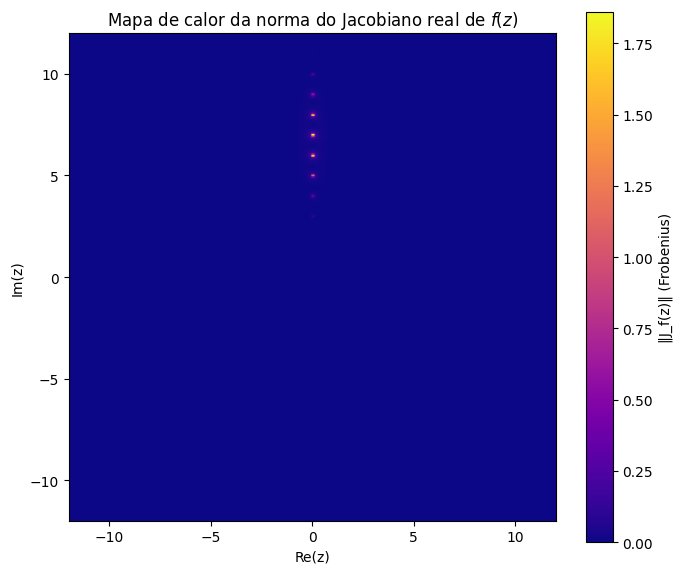

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Função complexa com singularidade
def f(z):
    return z**2 / ((z - 1)*(z-2)*(z-3)*(z-4)*(z-5)*(z-6)*(z-7)*(z-8)*(z-9)*(z-10)*(z-11)) # singularidade em z = 1

# Derivadas reais aproximadas
def compute_jacobian(z, h=1e-5):
    """
    Aproxima o Jacobiano real de f(z) = u(x,y) + iv(x,y)
    usando diferenças centrais em x e y.
    """
    x, y = z.real, z.imag
    f_x1 = f(x + h + 1j*y)
    f_x2 = f(x - h + 1j*y)
    f_y1 = f(x + 1j*(y + h))
    f_y2 = f(x + 1j*(y - h))

    df_dx = (f_x1 - f_x2) / (2*h)
    df_dy = (f_y1 - f_y2) / (2*h)

    u_x, v_x = df_dx.real, df_dx.imag
    u_y, v_y = df_dy.real, df_dy.imag

    J = np.array([[u_x, u_y],
                  [v_x, v_y]])
    return J

# Grid para mapa de calor
X = np.linspace(-12, 12, 300)
Y = np.linspace(-12, 12, 300)
xx, yy = np.meshgrid(X, Y)
zz = xx + 1j * yy

# Inicializa matriz de norma de Frobenius
J_norm = np.zeros_like(xx)

# Avalia norma de Frobenius do Jacobiano real
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        try:
            J = compute_jacobian(zz[i, j])
            J_norm[i, j] = np.linalg.norm(J, ord='fro')
        except:
            J_norm[i, j] = np.nan  # evita explosão perto da singularidade

# Plot do mapa de calor
plt.figure(figsize=(7, 6))
plt.imshow(J_norm.T, extent=[X.min(), X.max(), Y.min(), Y.max()],
           origin='lower', aspect='equal', cmap='plasma')
plt.colorbar(label='‖J_f(z)‖ (Frobenius)')
plt.title("Mapa de calor da norma do Jacobiano real de $f(z)$")
plt.xlabel("Re(z)"); plt.ylabel("Im(z)")
plt.tight_layout()
plt.show()


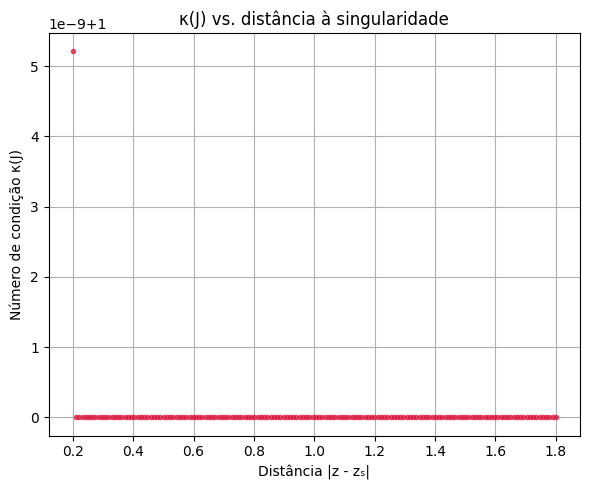

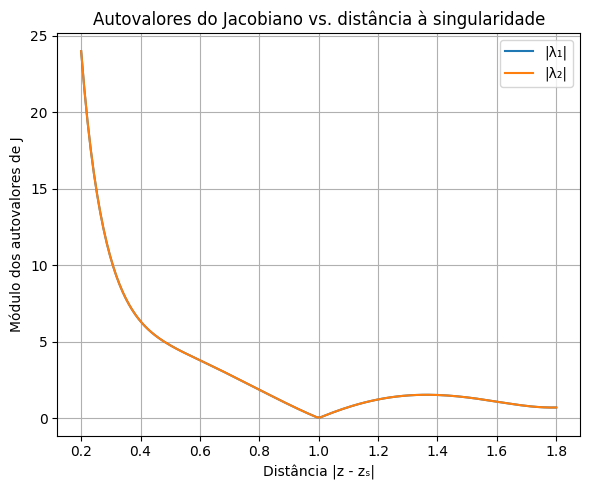

In [10]:
# Simula iterações de um solver se aproximando da singularidade
z_s = 1 + 0j  # singularidade
theta = np.linspace(0, 2*np.pi, 150)
radii = np.linspace(1.8, 0.2, 150)
z_path = z_s + radii * np.exp(1j * theta)  # espiral em torno da singularidade

distances = []
eig1 = []
eig2 = []
conds = []

for z in z_path:
    try:
        J = compute_jacobian(z)
        eigvals = np.linalg.eigvals(J)
        kappa = np.abs(eigvals).max() / np.abs(eigvals).min()
        
        distances.append(abs(z - z_s))
        eig1.append(np.abs(eigvals[0]))
        eig2.append(np.abs(eigvals[1]))
        conds.append(kappa)
    except:
        continue  # skip se singularidade ou erro numérico

# Plota número de condição vs. distância
plt.figure(figsize=(6, 5))
plt.plot(distances, conds, '.', alpha=0.7, color='crimson')
plt.xlabel('Distância |z - zₛ|')
plt.ylabel('Número de condição κ(J)')
plt.title('κ(J) vs. distância à singularidade')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plota autovalores vs. distância
plt.figure(figsize=(6, 5))
plt.plot(distances, eig1, label='|λ₁|')
plt.plot(distances, eig2, label='|λ₂|')
plt.xlabel('Distância |z - zₛ|')
plt.ylabel('Módulo dos autovalores de J')
plt.legend()
plt.title('Autovalores do Jacobiano vs. distância à singularidade')
plt.grid(True)
plt.tight_layout()
plt.show()


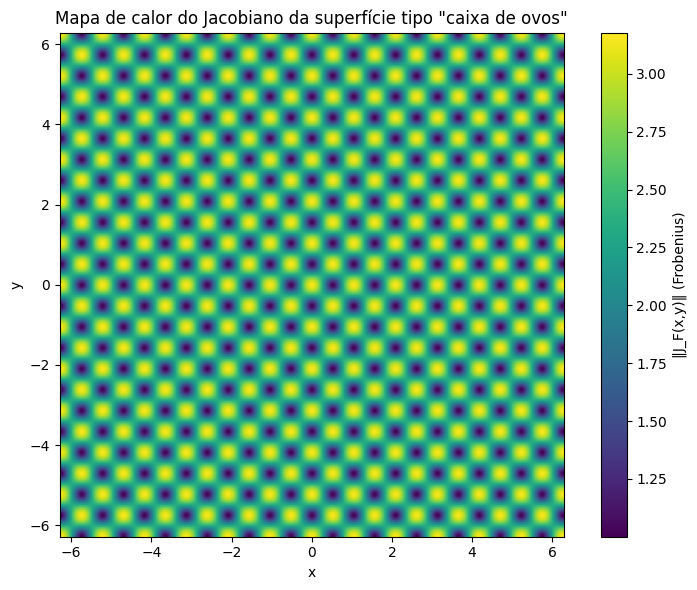

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Superfície tipo "caixa de ovos"
def f(x, y):
    return np.sin(3 * x) * np.cos(3 * y)

# Cria grid
X = np.linspace(-2*np.pi, 2*np.pi, 300)
Y = np.linspace(-2*np.pi, 2*np.pi, 300)
xx, yy = np.meshgrid(X, Y)
zz = f(xx, yy)

# Gradientes da função f(x, y)
fx, fy = np.gradient(zz, X, Y, edge_order=2)

# Jacobiano da parametrização F(x, y) = [x, y, f(x,y)]
# em cada ponto, a matriz J_F é 3x2. Aqui calculamos norm²(J) ou det²(J^T J)

# Exemplo: norma de Frobenius do Jacobiano (p/ cada ponto)
J_norm = np.sqrt(1 + fx**2 + fy**2)  # ||[1,0,f_x], [0,1,f_y]||_F

# Mapa de calor da norma do Jacobiano
plt.figure(figsize=(8,6))
plt.imshow(J_norm.T, extent=[X.min(), X.max(), Y.min(), Y.max()],
           origin='lower', cmap='viridis', aspect='equal')
plt.colorbar(label='‖J_F(x,y)‖ (Frobenius)')
plt.title('Mapa de calor do Jacobiano da superfície tipo "caixa de ovos"')
plt.xlabel('x'); plt.ylabel('y')
plt.tight_layout()
plt.show()


In [20]:
import numpy as np

# --- 1) Definições da superfície e do grid ---
def f(x, y):
    return np.sin(3 * x) * np.cos(3 * y)

# grid reduzido só para demonstração (pode ampliar para 300×300)
X = np.linspace(-np.pi, np.pi, 5)
Y = np.linspace(-np.pi, np.pi, 5)
xx, yy = np.meshgrid(X, Y)
zz = f(xx, yy)

# --- 2) Cálculo dos gradientes ∂f/∂x, ∂f/∂y via diferenças finitas ---
fx, fy = np.gradient(zz, X, Y, edge_order=2)

# --- 3) Para cada ponto, monta J_F (3×2) e imprime eig(J^T J) ---
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        # Jacobiano da imersão F(x,y) = [x, y, f(x,y)]
        # colunas = ∂F/∂x, ∂F/∂y
        J = np.array([
            [1,      0],
            [0,      1],
            [fx[i,j], fy[i,j]]
        ])  # shape = (3,2)
        
        # matriz simétrica 2×2
        JTJ = J.T @ J
        
        # autovalores de J^T J
        eigs = np.linalg.eigvals(JTJ)
        
        print(f"Ponto (x={xx[i,j]:.2f}, y={yy[i,j]:.2f}) → eig(JᵀJ) = {eigs}")


Ponto (x=-3.14, y=-3.14) → eig(JᵀJ) = [1.         2.62113894]
Ponto (x=-1.57, y=-3.14) → eig(JᵀJ) = [1.40528473 1.        ]
Ponto (x=0.00, y=-3.14) → eig(JᵀJ) = [1.         1.40528473]
Ponto (x=1.57, y=-3.14) → eig(JᵀJ) = [1.40528473 1.        ]
Ponto (x=3.14, y=-3.14) → eig(JᵀJ) = [1.         2.62113894]
Ponto (x=-3.14, y=-1.57) → eig(JᵀJ) = [1. 1.]
Ponto (x=-1.57, y=-1.57) → eig(JᵀJ) = [1.40528473 1.        ]
Ponto (x=0.00, y=-1.57) → eig(JᵀJ) = [1. 1.]
Ponto (x=1.57, y=-1.57) → eig(JᵀJ) = [1.40528473 1.        ]
Ponto (x=3.14, y=-1.57) → eig(JᵀJ) = [1. 1.]
Ponto (x=-3.14, y=0.00) → eig(JᵀJ) = [1.         2.62113894]
Ponto (x=-1.57, y=0.00) → eig(JᵀJ) = [1. 1.]
Ponto (x=0.00, y=0.00) → eig(JᵀJ) = [1.         1.40528473]
Ponto (x=1.57, y=0.00) → eig(JᵀJ) = [1. 1.]
Ponto (x=3.14, y=0.00) → eig(JᵀJ) = [1.         2.62113894]
Ponto (x=-3.14, y=1.57) → eig(JᵀJ) = [1. 1.]
Ponto (x=-1.57, y=1.57) → eig(JᵀJ) = [1.40528473 1.        ]
Ponto (x=0.00, y=1.57) → eig(JᵀJ) = [1. 1.]
Ponto (x=1.57,

In [21]:
import numpy as np

# --- 1) Definições da superfície e do grid ---
def f(x, y):
    return np.sin(3 * x) * np.cos(3 * y)

# grid de exemplo (pode refinar para mais pontos)
X = np.linspace(-np.pi, np.pi, 5)
Y = np.linspace(-np.pi, np.pi, 5)
xx, yy = np.meshgrid(X, Y)
zz = f(xx, yy)

# --- 2) Gradientes ∂f/∂x, ∂f/∂y via diferenças finitas ---
fx, fy = np.gradient(zz, X, Y, edge_order=2)

# --- 3) Para cada ponto, monta J_F (3×2) e imprime cond(J_F) ---
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        # Jacobiano da imersão F(x,y) = [x, y, f(x,y)]
        J = np.array([
            [1,        0],
            [0,        1],
            [fx[i, j], fy[i, j]]
        ])  # forma (3,2)
        
        # número de condição de J (métrica 2-norma)
        cond_J = np.linalg.cond(J)
        
        print(f"Ponto (x={xx[i,j]:.2f}, y={yy[i,j]:.2f}) → cond(J_F) = {cond_J:.2e}")


Ponto (x=-3.14, y=-3.14) → cond(J_F) = 1.62e+00
Ponto (x=-1.57, y=-3.14) → cond(J_F) = 1.19e+00
Ponto (x=0.00, y=-3.14) → cond(J_F) = 1.19e+00
Ponto (x=1.57, y=-3.14) → cond(J_F) = 1.19e+00
Ponto (x=3.14, y=-3.14) → cond(J_F) = 1.62e+00
Ponto (x=-3.14, y=-1.57) → cond(J_F) = 1.00e+00
Ponto (x=-1.57, y=-1.57) → cond(J_F) = 1.19e+00
Ponto (x=0.00, y=-1.57) → cond(J_F) = 1.00e+00
Ponto (x=1.57, y=-1.57) → cond(J_F) = 1.19e+00
Ponto (x=3.14, y=-1.57) → cond(J_F) = 1.00e+00
Ponto (x=-3.14, y=0.00) → cond(J_F) = 1.62e+00
Ponto (x=-1.57, y=0.00) → cond(J_F) = 1.00e+00
Ponto (x=0.00, y=0.00) → cond(J_F) = 1.19e+00
Ponto (x=1.57, y=0.00) → cond(J_F) = 1.00e+00
Ponto (x=3.14, y=0.00) → cond(J_F) = 1.62e+00
Ponto (x=-3.14, y=1.57) → cond(J_F) = 1.00e+00
Ponto (x=-1.57, y=1.57) → cond(J_F) = 1.19e+00
Ponto (x=0.00, y=1.57) → cond(J_F) = 1.00e+00
Ponto (x=1.57, y=1.57) → cond(J_F) = 1.19e+00
Ponto (x=3.14, y=1.57) → cond(J_F) = 1.00e+00
Ponto (x=-3.14, y=3.14) → cond(J_F) = 1.62e+00
Ponto (x=-1.57,